 # 1. Постановка задачи

## 1.1 Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса

## 1.2 Описание технологического процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

## 1.3 Описание даннных

Данные состоят из нескольких файлов, полученных из разных источников:  
- data_arc_new.csv — данные об электродах;  
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);  
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);  
- data_gas_new.csv — данные о продувке сплава газом;  
- data_temp_new.csv — результаты измерения температуры;  
- data_wire_new.csv — данные о проволочных материалах (объём);  
- data_wire_time_new.csv — данные о проволочных материалах (время)

Файл data_arc_new.csv

- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.cs:

- key — номер партии;  
- Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл data_bulk_time_new.csv:
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv:
- key — номер партии;
- Газ 1 — объём подаваемого газа.

Файл data_temp_new.csv:

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

Файл data_wire_new.csv:

- key — номер партии;
- Wire 1 … Wire 15 — объём подаваемых проволочных материалов

Файл data_wire_time_new.csv

- key — номер партии;
- Wire 1 … Wire 15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## 1.4 Постановка задчи

Построить модель, которая предскажет температуру в системе "печь-ковш"(кислородного конвертера) при выплавке стали кислородно-конвертерным способом в конвертерном цеху металургического комбината.

Модель должна иметь метрику MAE < 6.8 на тестовой выборке

# 2. Импорт библиотек и датасета

## 2.1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from IPython.core.display import display, HTML;
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.pipeline import make_pipeline

/var/folders/5m/tbwsb3vs6734vbbw653my9v00000gp/T/ipykernel_56356/2260187450.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML;


In [2]:
warnings.filterwarnings('ignore') #Игнорируем ошибки

In [3]:
display(HTML("<style>.container { width:90% !important; }</style>")) # Изменяем ширину тетради

## 2.2. Импорт датасета

In [4]:
def import_data(pth1:str, pth2:str) -> pd.DataFrame:
    try:
        df = pd.read_csv(pth1) #Парсим дату
    except OSError as e:
         df = pd.read_csv(pth2)
    return df

In [5]:
pth1 = ['https://code.s3.yandex.net/datasets/data_arc_new.csv',
        'https://code.s3.yandex.net/datasets/data_bulk_new.csv',
        'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv',
        'https://code.s3.yandex.net/datasets/data_gas_new.csv',
        'https://code.s3.yandex.net/datasets/data_temp_new.csv',
        'https://code.s3.yandex.net/datasets/data_wire_new.csv',
        'https://code.s3.yandex.net/datasets/data_wire_time_new.csv'
]

In [6]:
pth2 = ['/Documents/GitHub/final_project/data_arc_new.csv', 
        '/Documents/GitHub/final_project/data_bulk_new.csv',
        '/Documents/GitHub/final_project/data_bulk_time_new.csv',
        '/Documents/GitHub/final_project/data_gas_new.csv',
        '/Documents/GitHub/final_project/data_temp_new.csv',
        '/Documents/GitHub/final_project/data_wire_new.csv',
        '/Documents/GitHub/final_project/data_wire_time_new.csv'
]

In [7]:
arc_new = import_data(pth1[0], pth2[0]) #данные об электродах;
bulk_new = import_data(pth1[1], pth2[1]) #данные о подаче сыпучих материалов (объём);  
bulk_time_new = import_data(pth1[2], pth2[2]) #данные о подаче сыпучих материалов (время);  
gas_new = import_data(pth1[3], pth2[3]) #результаты измерения температуры;
temp_new = import_data(pth1[4], pth2[4]) #данные о проволочных материалах (объём);  
wire_new = import_data(pth1[5], pth2[5])#данные о проволочных материалах (объем);
wire_time_new = import_data(pth1[6], pth2[6]) #данные о проволочных материалах (время)

In [8]:
arc_new.info()
arc_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
12114,2634,2019-08-15 15:26:57,2019-08-15 15:28:16,0.823667,0.570979
36,9,2019-05-03 15:49:07,2019-05-03 15:52:23,0.492036,0.317230
852,180,2019-05-10 13:05:28,2019-05-10 13:07:40,1.169671,0.880475
11218,2442,2019-08-08 11:48:51,2019-08-08 11:51:16,1.242748,0.955753
1564,335,2019-05-16 11:29:29,2019-05-16 11:32:52,0.468791,0.323527


In [9]:
bulk_new.info()
bulk_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1357,1410,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN,NaN,NaN,NaN,281.0,NaN,217.0,159.0
214,231,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,253.0,NaN,104.0,203.0
1441,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN
2778,2882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,NaN,152.0,58.0
2292,2375,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.0,NaN


In [10]:
bulk_time_new.info()
bulk_time_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
32,33,NaN,NaN,2019-05-04 14:35:49,2019-05-04 14:33:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-04 14:22:38,NaN,2019-05-04 14:16:49,2019-05-04 14:13:32
1436,1490,NaN,NaN,2019-06-28 11:42:38,2019-06-28 11:42:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-28 11:42:38,NaN,2019-06-28 11:54:10,2019-06-28 11:42:38
1487,1544,NaN,NaN,NaN,2019-06-30 16:23:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-30 16:20:02,NaN,2019-06-30 16:05:51,2019-06-30 15:57:45
1499,1556,NaN,NaN,NaN,2019-06-30 23:28:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-30 23:43:48,NaN,2019-06-30 23:52:40,2019-06-30 23:43:48
1816,1878,NaN,NaN,NaN,NaN,NaN,2019-07-12 03:28:59,NaN,NaN,NaN,NaN,2019-07-12 03:15:38,NaN,NaN,2019-07-12 02:57:21,NaN


In [11]:
gas_new.info()
gas_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
2405,2408,21.884559
1853,1856,9.410459
1083,1086,12.067864
1470,1473,9.586852
3052,3055,15.284548


In [12]:
temp_new.info()
temp_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
10585,1893,2019-07-13 01:16:39,1598.0
7465,1339,2019-06-22 18:19:38,1602.0
11451,2045,2019-07-25 01:37:52,1578.0
16012,2862,2019-08-24 04:17:59,NaN
2728,482,2019-05-21 23:57:19,1600.0


In [13]:
wire_new.info()
wire_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2904,3063,109.199997,76.153999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1818,1908,175.078796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,947,123.037201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2409,2536,36.036000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,1061,157.014000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
wire_time_new.info()
wire_time_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1664,1750,2019-07-07 08:05:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1904,1998,2019-07-23 09:03:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
832,886,2019-06-06 21:06:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2644,2778,2019-08-21 00:42:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1357,1428,2019-06-26 01:22:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.Исследовательский анализ и предобработка данных

## 3.1 Предобработка данных

In [15]:
def print_info(df:pd.DataFrame):
    print('Пропуски')
    print(df.isna().sum())
    print('Дубликаты')
    print(df.duplicated().sum())
    return

**arc_new**

Приведем наименования признаков в соответствие со snake_case

In [16]:
arc_new.columns = ['key', 'start_of_heating', 'end_of_heating', 'active_power', 'reactive_power']

In [17]:
arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14876 non-null  int64  
 1   start_of_heating  14876 non-null  object 
 2   end_of_heating    14876 non-null  object 
 3   active_power      14876 non-null  float64
 4   reactive_power    14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Приведем время к date_time

In [18]:
arc_new.start_of_heating = pd.to_datetime(arc_new.start_of_heating, infer_datetime_format = True) 
arc_new.end_of_heating = pd.to_datetime(arc_new.end_of_heating, infer_datetime_format = True) 

In [19]:
arc_new.info()
arc_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14876 non-null  int64         
 1   start_of_heating  14876 non-null  datetime64[ns]
 2   end_of_heating    14876 non-null  datetime64[ns]
 3   active_power      14876 non-null  float64       
 4   reactive_power    14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,start_of_heating,end_of_heating,active_power,reactive_power
12934,2810,2019-08-22 06:10:39,2019-08-22 06:12:13,0.511479,0.387094
13089,2847,2019-08-23 12:52:29,2019-08-23 12:54:06,1.220034,0.852324
7630,1657,2019-07-04 07:20:34,2019-07-04 07:22:39,0.656099,0.516750
3138,680,2019-05-29 22:53:17,2019-05-29 22:55:05,0.440410,0.382738
7781,1687,2019-07-05 06:37:49,2019-07-05 06:39:55,0.535782,0.375477


Проверим пропуски

In [20]:
print_info(arc_new)

Пропуски
key                 0
start_of_heating    0
end_of_heating      0
active_power        0
reactive_power      0
dtype: int64
Дубликаты
0


Пропусков явных дубикатов нет

In [21]:
arc_new.describe()

,key,start_of_heating,end_of_heating,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


значения меньше 0 для реактивной мощности явно ошибочны

In [22]:
arc_new[arc_new.reactive_power > 0].count()

key                 14875
start_of_heating    14875
end_of_heating      14875
active_power        14875
reactive_power      14875
dtype: int64

In [24]:
keys_to_delete = arc_new[arc_new.reactive_power < 0].key.values[0]

In [25]:
keys_to_delete 

2116

In [26]:
arc_new = arc_new[arc_new.key != keys_to_delete]

In [27]:
arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14872 non-null  int64         
 1   start_of_heating  14872 non-null  datetime64[ns]
 2   end_of_heating    14872 non-null  datetime64[ns]
 3   active_power      14872 non-null  float64       
 4   reactive_power    14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


In [28]:
arc_new[arc_new.reactive_power < 0].count()

key                 0
start_of_heating    0
end_of_heating      0
active_power        0
reactive_power      0
dtype: int64

In [29]:
arc_new.describe()

,key,start_of_heating,end_of_heating,active_power,reactive_power
count,14872.000000,14872,14872,14872.000000,14872.000000
mean,1615.085732,2019-07-05 12:17:07.251008512,2019-07-05 12:19:58.939012864,0.662753,0.487112
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777
25%,806.000000,2019-06-03 23:00:25.249999872,2019-06-03 23:04:15.750000128,0.467114,0.337175
50%,1616.000000,2019-07-03 01:13:25,2019-07-03 01:15:47,0.599587,0.441667
75%,2429.000000,2019-08-07 22:59:29.500000,2019-08-07 23:01:33,0.830314,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.661090,NaN,NaN,0.258916,0.197623


**bulk_new**

Проверим пропуски и дубликаты

In [30]:
print_info(bulk_new)

Пропуски
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
Дубликаты
0


Скорее всего пропуски связаны с тем, что в указанные плавки материалы не подавались (Объем 0). Логично заполнить данные пропуски 0

In [31]:
bulk_new = bulk_new.fillna(0)

In [32]:
print_info(bulk_new)

Пропуски
key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64
Дубликаты
0


Приведем признаки к snake_case

In [33]:
bulk_new.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [34]:
bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [35]:
bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Отрицательных значений нет

**bulk_time_new**

Приведем к snake_case

In [36]:
bulk_time_new.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [37]:
columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

В данном случае пропуски придется оставить, так как если материал не подавался в принципе, время подачи определить нельзя

In [38]:
bulk_time_new = bulk_time_new.fillna(0)

In [39]:
bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_2   3129 non-null   object
 3   bulk_3   3129 non-null   object
 4   bulk_4   3129 non-null   object
 5   bulk_5   3129 non-null   object
 6   bulk_6   3129 non-null   object
 7   bulk_7   3129 non-null   object
 8   bulk_8   3129 non-null   object
 9   bulk_9   3129 non-null   object
 10  bulk_10  3129 non-null   object
 11  bulk_11  3129 non-null   object
 12  bulk_12  3129 non-null   object
 13  bulk_13  3129 non-null   object
 14  bulk_14  3129 non-null   object
 15  bulk_15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


Приведем к date_time

In [40]:
def to_datetime(columns:str, df:pd.DataFrame) -> pd.DataFrame:
    for column in columns:
        df[column] = pd.to_datetime(df[column], infer_datetime_format = True, errors='coerce') 
    return df

In [41]:
bulk_time_new = to_datetime(columns, bulk_time_new)

In [42]:
print_info(bulk_time_new)

Пропуски
key           0
bulk_1        0
bulk_2        0
bulk_3        0
bulk_4     2115
bulk_5        0
bulk_6        0
bulk_7        0
bulk_8        0
bulk_9        0
bulk_10       0
bulk_11       0
bulk_12     679
bulk_13       0
bulk_14     323
bulk_15     881
dtype: int64
Дубликаты
0


In [43]:
bulk_time_new.sample(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1215,1264,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,2019-06-20 03:52:16,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,2019-06-20 04:08:59,1970-01-01,2019-06-20 04:03:33,2019-06-20 03:59:06
2347,2432,1970-01-01 00:00:00,1970-01-01,2019-08-08 00:47:24,NaT,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,2019-08-08 00:47:24,1970-01-01,2019-08-08 00:47:24,2019-08-08 00:55:29
2074,2146,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,NaT,1970-01-01,2019-07-29 02:15:35,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,2019-07-29 02:26:10,1970-01-01,2019-07-29 02:15:35,2019-07-29 01:57:58
142,156,2019-05-09 14:14:29,1970-01-01,1970-01-01 00:00:00,NaT,1970-01-01,2019-05-09 14:35:20,1970-01-01,1970-01-01,1970-01-01,1970-01-01,2019-05-09 14:23:12,2019-05-09 14:41:45,1970-01-01,2019-05-09 14:35:20,2019-05-09 14:23:12
2510,2605,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,NaT,1970-01-01,2019-08-14 14:16:32,1970-01-01,1970-01-01,1970-01-01,1970-01-01,2019-08-14 14:10:22,NaT,1970-01-01,2019-08-14 14:00:39,NaT


**gas_new**

In [44]:
print_info(gas_new)

Пропуски
key      0
Газ 1    0
dtype: int64
Дубликаты
0


Пропусков и дубликатов нет. Приведем признаки к snake_case

In [45]:
gas_new.columns = ['key', 'gas']

In [46]:
gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**temp_new**

Посмотрим пропуски и дубликаты

In [47]:
print_info(temp_new)

Пропуски
key                0
Время замера       0
Температура     3427
dtype: int64
Дубликаты
0


К сожалению в данном случае пропуски не заполнить. Так как это целевой признак, придется удалить пропуски. 

In [49]:
temp_new = temp_new.fillna(0)

Приведем столбцы к snake_case

In [50]:
temp_new.columns = ['key', 'measurment_time', 'temperature']

In [51]:
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              18092 non-null  int64  
 1   measurment_time  18092 non-null  object 
 2   temperature      18092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


**wire_new**

In [52]:
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [53]:
print_info(wire_new)

Пропуски
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Дубликаты
0


Скорее всего пропуски - это отсутсвие материалов, т.е 0

In [54]:
wire_new = wire_new.fillna(0)

Приведем признаки к snake_case

In [55]:
wire_new.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [56]:
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**wire_time_new**

In [57]:
print_info(wire_time_new)

Пропуски
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Дубликаты
0


Здесь с пропусками ничего сделать не поулчится. Приведем к snake_case и date_time

In [58]:
wire_time_new.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [59]:
wire_time_new = to_datetime(columns, wire_time_new)

**Вывод:**

В ходе данного этапа была произведена предобработка данных. 
Выявлено следующее:

1. Признаках реактивной мощности и температуры присутствуют аномальные значения (отрицательное и <1500 град.С)
2. В датасетах bulk, bulk_time, wire, wire_time, temp присутствуют пропуски
3. Даты подгруженны не корректно
4. Наименования признаков отличаются от snake_case

В ходе этапа было выполнено:

1. В признаках bulk и wire пропуски были заполнены нулями, так как скорее всего NaN означает, что мтериал не подавался
2. Для дльнейшей работы пропуски в признаке temp были заполнены заглушкой
3. Наименования признков были приведены к snake_case
4. Даты приведены к date_time

## 3.2 Исследовательский анализ данных

Очевидно, что время подачи того или инного материала вряд ли как-то влияют на температуру. Будум рассматривать нагрев элетродами(arc_new), объем подаваемых материалов и проволки (bulk_new и wire_new), объем газа (gas_new), результаты измерения температуры

**arc_new**

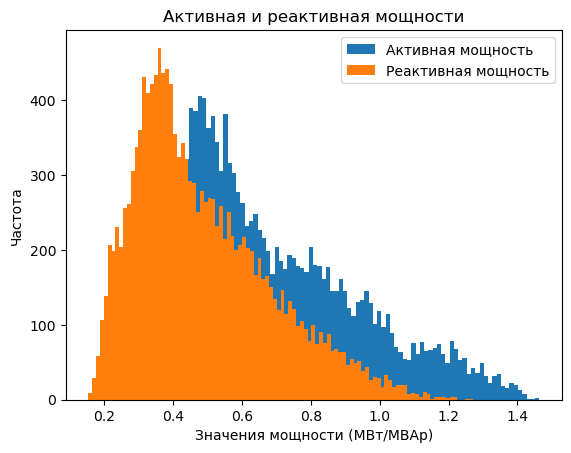

In [60]:
plt.title('Активная и реактивная мощности')
plt.hist(arc_new.active_power, bins= 100, label='Активная мощность');
plt.hist(arc_new.reactive_power, bins= 100, label='Реактивная мощность');
plt.legend(['Активная мощность', 'Реактивная мощность'])
plt.xlabel("Значения мощности (МВт/МВАр)")  
plt.ylabel("Частота")

plt.show()

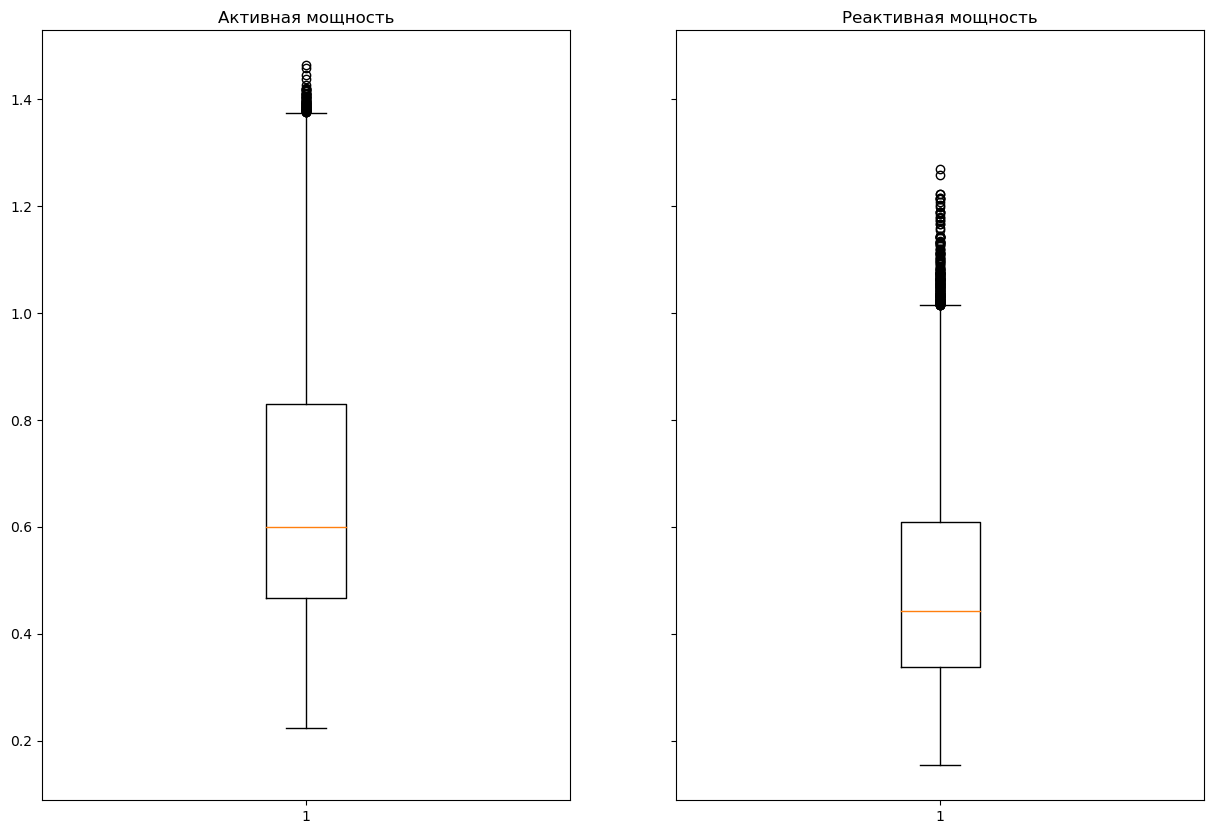

In [61]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
ax1.boxplot(arc_new.active_power);
ax1.set_title('Активная мощность');
ax2.boxplot(arc_new.reactive_power);
ax2.set_title('Реактивная мощность');

Из гистограмм видно, что активная и реактивная мощность сильно коррелируют друг другом (почти линейная зависимость). Для уменьшения эффекта мультиколинеарности расчитаем полную мощность

In [62]:
arc_new['full_power'] = (arc_new['active_power']**2 + arc_new['reactive_power']**2)**0.5

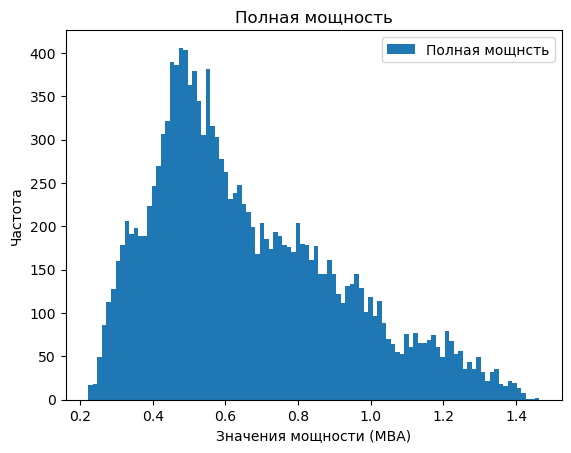

In [63]:
plt.title('Полная мощность')
plt.hist(arc_new.active_power, bins= 100, label='Полная мощность');

plt.legend(['Полная мощнсть'])
plt.xlabel("Значения мощности (МВА)")  
plt.ylabel("Частота")

plt.show()

Даты начала и конца сами по себе ничего не скажут, а продолжительность нагрева может быть важной

In [64]:
arc_new['time_of_heating'] = arc_new.end_of_heating - arc_new.start_of_heating

In [65]:
arc_new['time_of_heating'] = arc_new['time_of_heating'].map(lambda x: x.total_seconds()) #Переведем все в секунды

Text(0, 0.5, 'Частота')

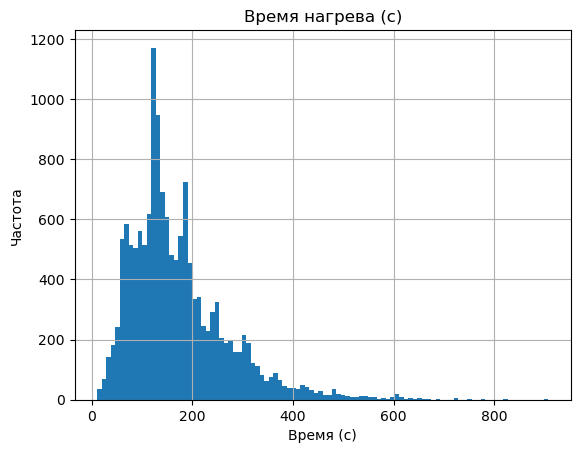

In [66]:
plt.title('Время нагрева (с)')
arc_new.time_of_heating.hist(bins = 100);
plt.xlabel("Время (с)")  
plt.ylabel("Частота")

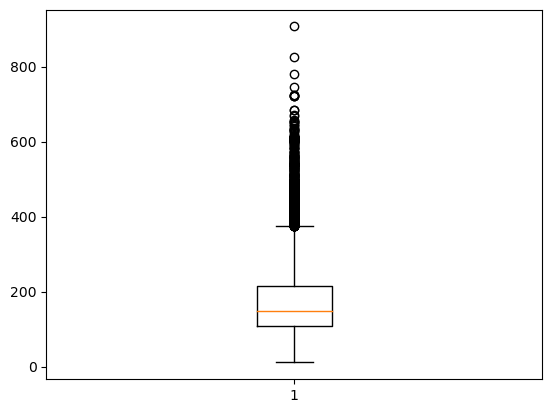

In [67]:
plt.boxplot(arc_new.time_of_heating);
ax1.set_title('Время нагрева');

Присутствует большое количество выбросов 

In [68]:
arc_new.describe()

,key,start_of_heating,end_of_heating,active_power,reactive_power,full_power,time_of_heating
count,14872.000000,14872,14872,14872.000000,14872.000000,14872.000000,14872.000000
mean,1615.085732,2019-07-05 12:17:07.251008512,2019-07-05 12:19:58.939012864,0.662753,0.487112,0.823385,171.688004
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,0.275718,11.000000
25%,806.000000,2019-06-03 23:00:25.249999872,2019-06-03 23:04:15.750000128,0.467114,0.337175,0.578813,107.000000
50%,1616.000000,2019-07-03 01:13:25,2019-07-03 01:15:47,0.599587,0.441667,0.746591,147.000000
75%,2429.000000,2019-08-07 22:59:29.500000,2019-08-07 23:01:33,0.830314,0.608201,1.030390,214.000000
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,1.898158,907.000000
std,934.661090,NaN,NaN,0.258916,0.197623,0.323494,98.193604


Рассмотрим средне и суммрное потребление электроэнергии при плавке каждой партии. Для этого с агрегируем датафрейм по ключу

In [69]:
arc_preprocessed = (arc_new.
                    drop(columns=['start_of_heating','end_of_heating', 'active_power', 'reactive_power'])
                    .groupby('key')
                    .agg('median'))

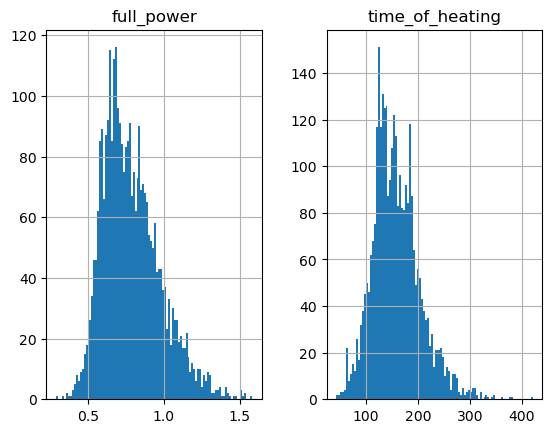

In [70]:
arc_preprocessed.hist(bins = 100);

In [71]:
arc_new.groupby('key').full_power.agg('mean')

key
1       0.743747
2       0.647087
3       1.003845
4       0.850010
5       0.704245
          ...   
3237    0.650131
3238    0.574646
3239    0.751810
3240    0.816584
3241    0.744576
Name: full_power, Length: 3213, dtype: float64

Так как в дальнейшем нам пданные за каждую итерацию не понадобятся, выберем среднее 

Вывод: 

- храктер распределения - распределение пуассона (усредненно для каждой партии близко к нормальному)
- присутствуют выбросы за гранцие 4-ого квартиля
- В среднем на разогрев уходит 171 секунда при 0.663 МВт активной мощности и 0.487 МВАр реактивной мощности

**gas_new**

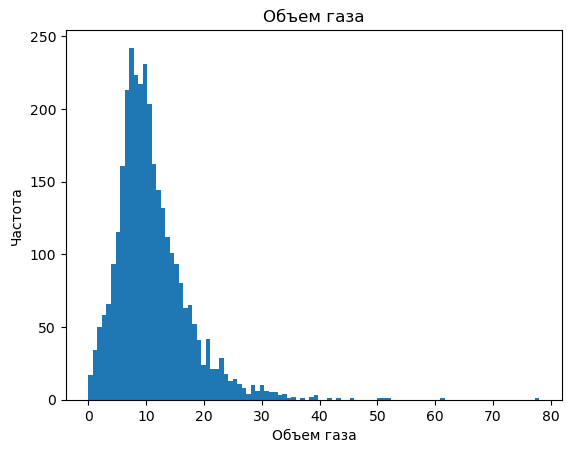

In [72]:
plt.title('Объем газа')
plt.hist(gas_new.gas, bins= 100);
plt.xlabel("Объем газа")  
plt.ylabel("Частота")
plt.show()

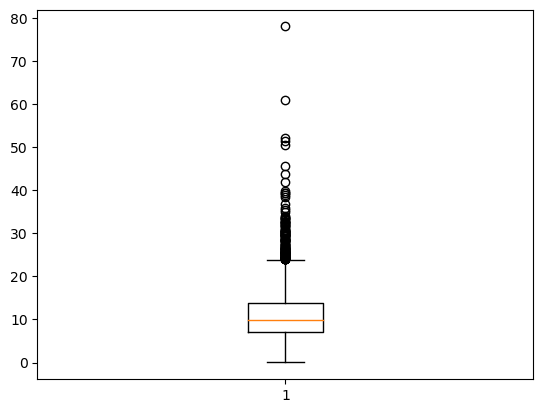

In [73]:
plt.boxplot(gas_new.gas);
ax1.set_title('Объем газа');

In [74]:
gas_new.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Вывод: 

- хактер распределения - распределение пуассона
- присутствуют выбросы за гранцей 4-ого квартиля
- В среднем за плавку подается 11 чего-то (скорее всего м3) кислорода 

Исследуем выбросы. Посмотрим что проиходило в партиях, где замечены выбросы по газу

In [75]:
gas_new.gas.sort_values(ascending = False)

319     77.995040
277     60.935689
2107    52.142373
2567    51.380229
116     50.581035
          ...    
352      0.325733
2353     0.275081
2100     0.263029
1044     0.016696
863      0.008399
Name: gas, Length: 3239, dtype: float64

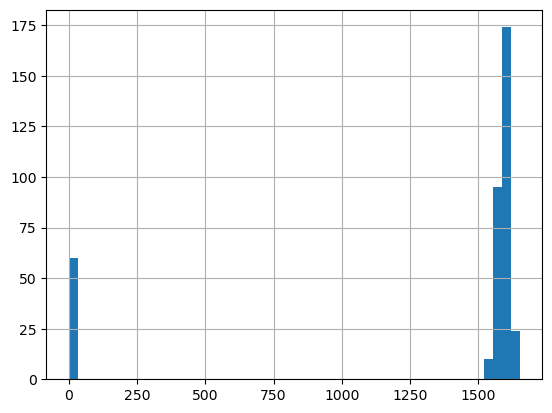

In [76]:
temp_new[temp_new.key.isin(gas_new[gas_new.gas > 30.0].key)].temperature.hist(bins=50);

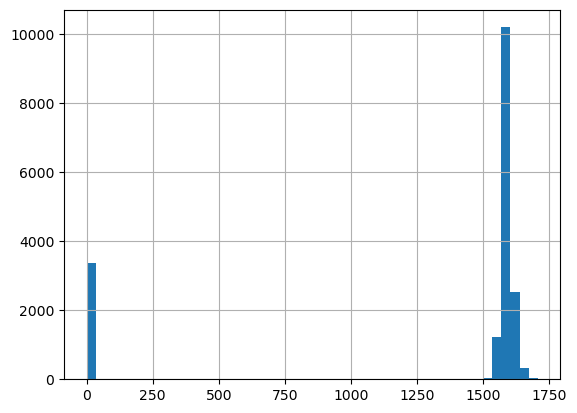

In [77]:
temp_new[temp_new.key.isin(gas_new[gas_new.gas < 30.0].key)].temperature.hist(bins=50);

In [78]:
temp_new[temp_new.key.isin(gas_new[gas_new.gas > 30.0].key)].groupby('key').key.count().sort_values(ascending = False)

key
2108    17
1513    16
1689    16
2567    15
322     14
1958    12
1014    11
692     10
2570    10
280     10
663      9
1881     9
2858     9
528      8
2510     8
2477     8
1021     8
118      7
263      7
1932     7
117      7
1333     7
2515     7
613      7
346      7
814      7
2781     7
671      7
2261     6
2850     6
2473     6
2993     6
2110     6
1373     6
1142     6
761      6
693      6
281      6
2268     5
2464     5
1727     5
1464     5
356      5
106      5
2250     3
2233     3
Name: key, dtype: int64

In [79]:
temp_new[temp_new.key.isin(gas_new[gas_new.gas < 30.0].key)].groupby('key').key.count().sort_values(ascending = False)

key
46      14
1829    13
44      13
2916    13
2926    12
        ..
1914     2
269      2
556      2
195      1
279      1
Name: key, Length: 3168, dtype: int64

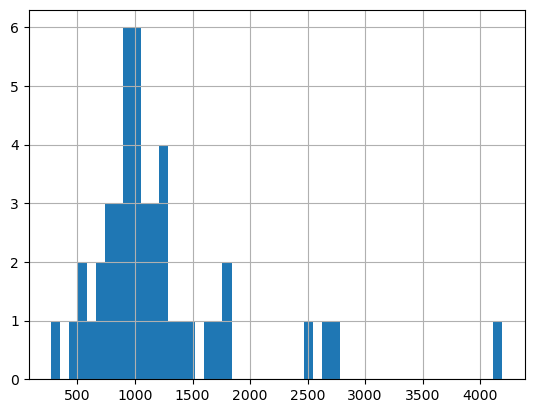

In [80]:
(arc_new[arc_new.key.isin(gas_new[gas_new.gas > 30.0].key)]
 .drop(columns = ['start_of_heating', 'end_of_heating'])
 .groupby('key')
 .agg('sum')
 .time_of_heating.hist(bins = 50));

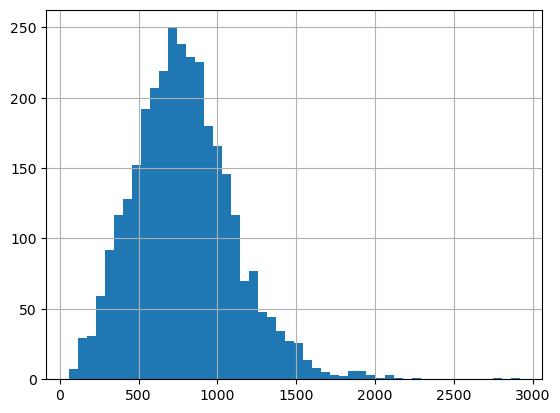

In [81]:
(arc_new[arc_new.key.isin(gas_new[gas_new.gas < 30.0].key)]
 .drop(columns = ['start_of_heating', 'end_of_heating'])
 .groupby('key')
 .agg('sum')
 .time_of_heating.hist(bins = 50));

In [82]:
gas_new[gas_new.key == 2108]

,key,gas
2105,2108,45.638999


In [83]:
def plot_cycle(df:pd.DataFrame, columns:list, string:int, col:int, bins):
    fig, axs = plt.subplots(string,col, figsize= (20,20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i in range(len(columns)):

        axs[i].hist(df[columns[i]],bins)
        axs[i].set_title(columns[i])
    return 

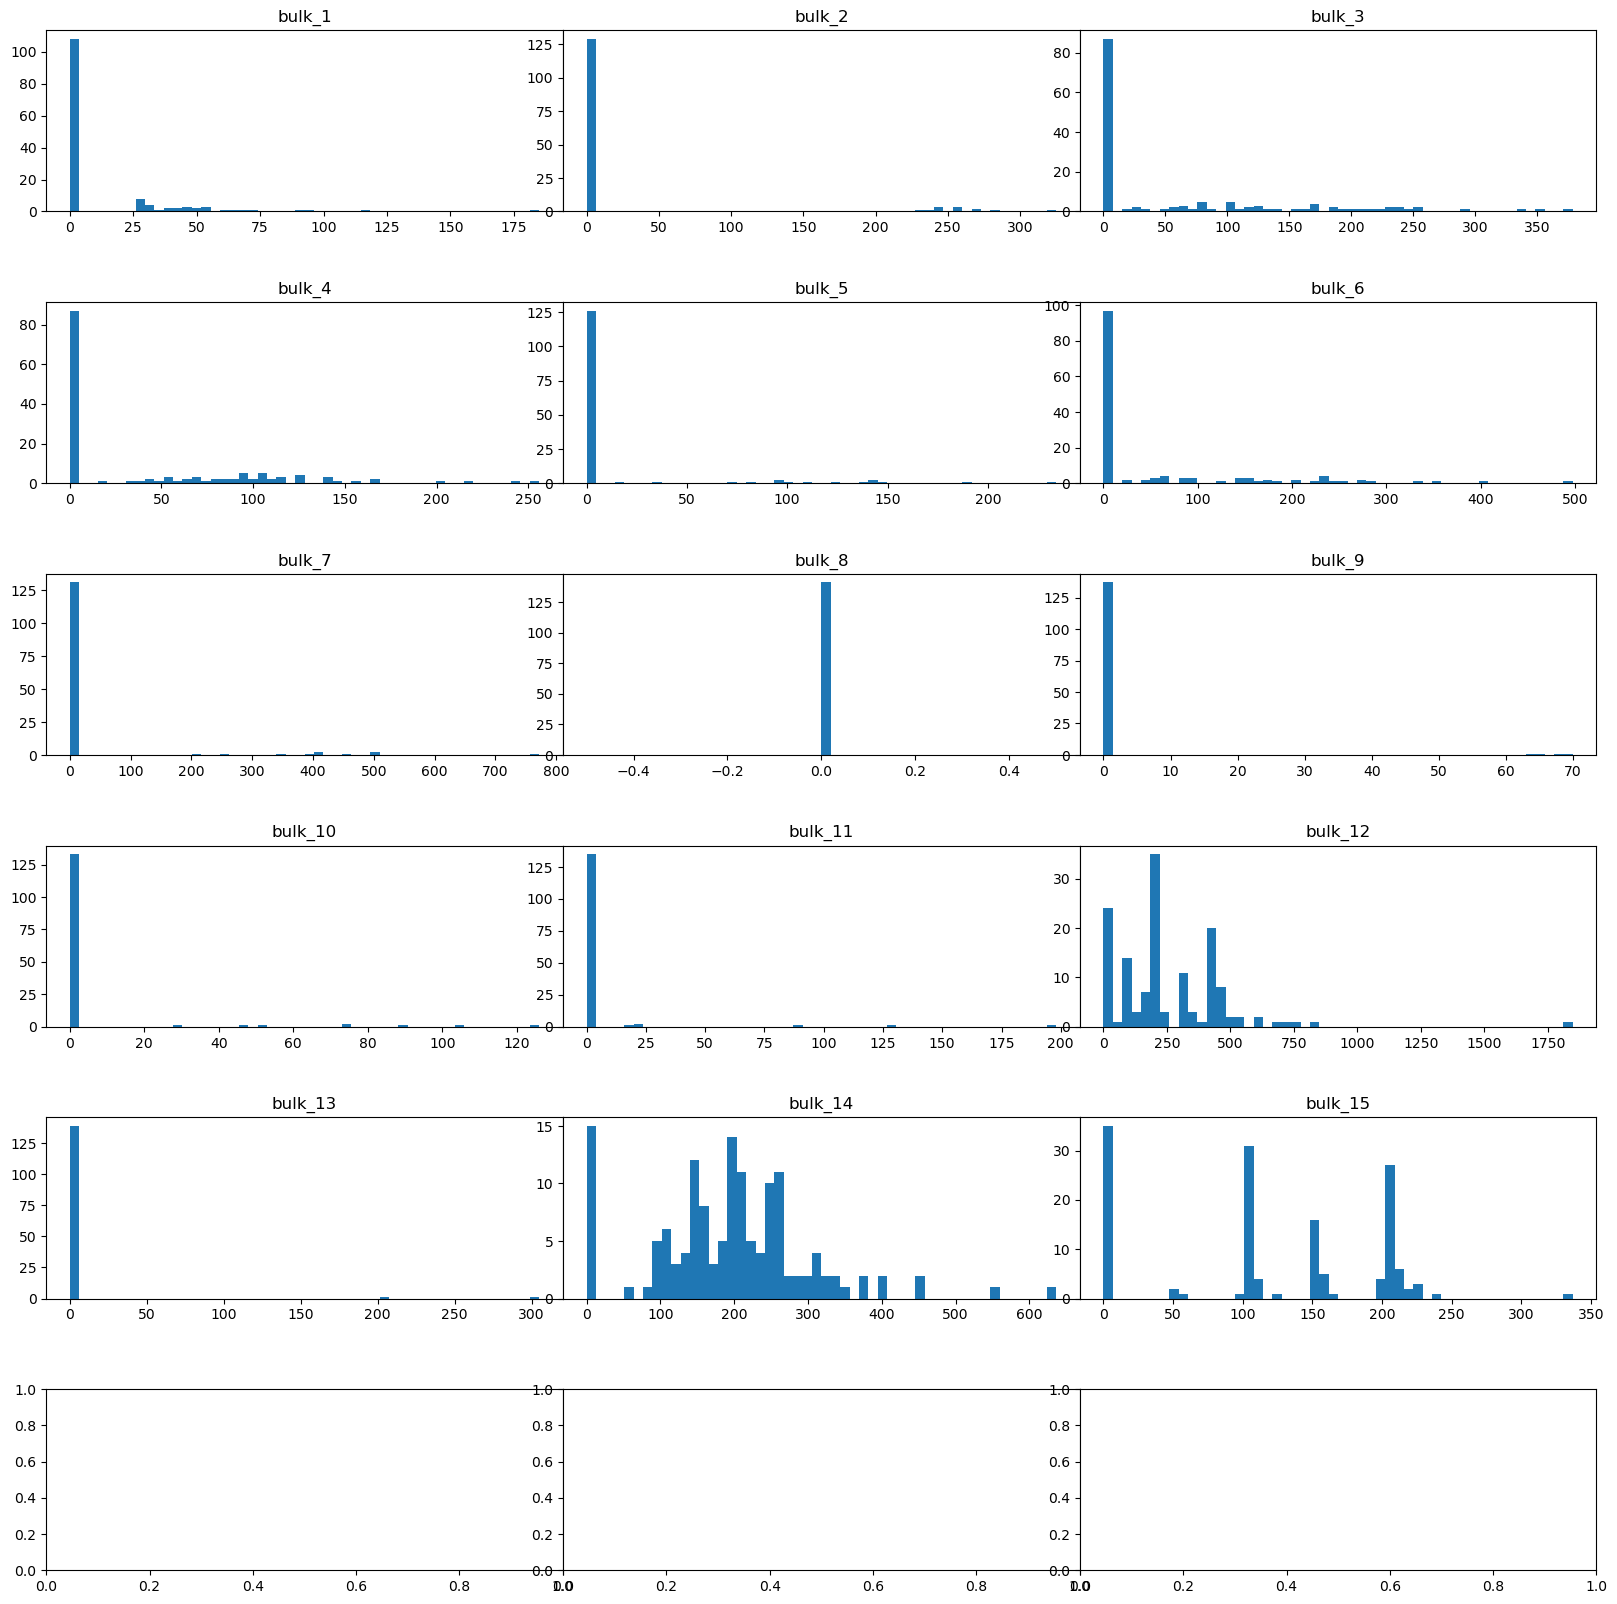

In [84]:
plot_cycle(bulk_new[bulk_new.key.isin(gas_new[gas_new.gas > 23.0].key)], bulk_new.columns.drop('key'), 6,3,50) 

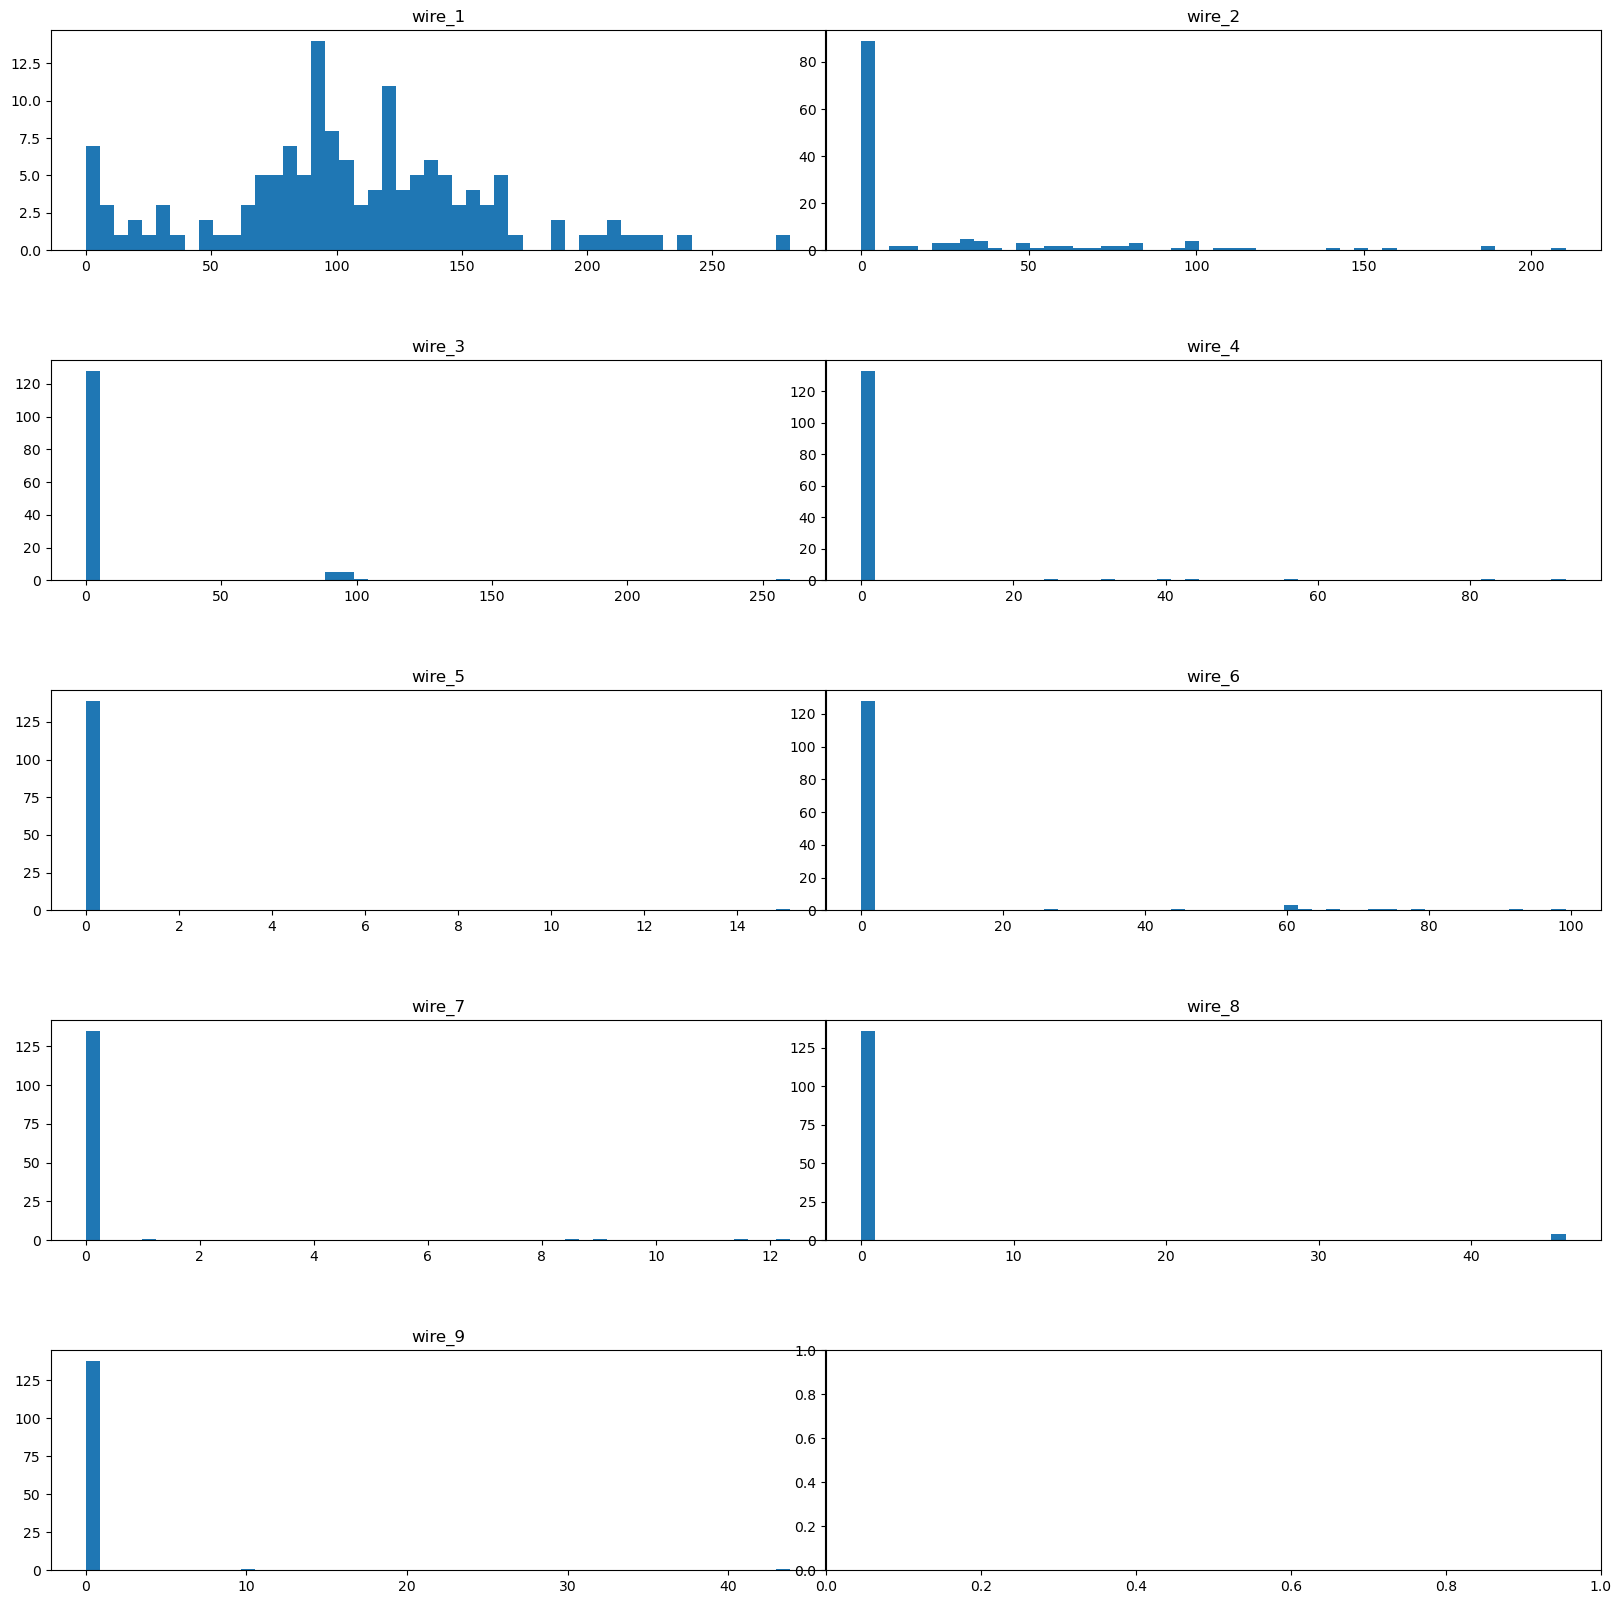

In [85]:
plot_cycle(wire_new[wire_new.key.isin(gas_new[gas_new.gas > 23.0].key)], wire_new.columns.drop('key'), 5,2,50) 

**Вывод**:

Скорее всего увеличенный расход газа связан с увеличением температуры и количеством итерраций 

**temp_new**

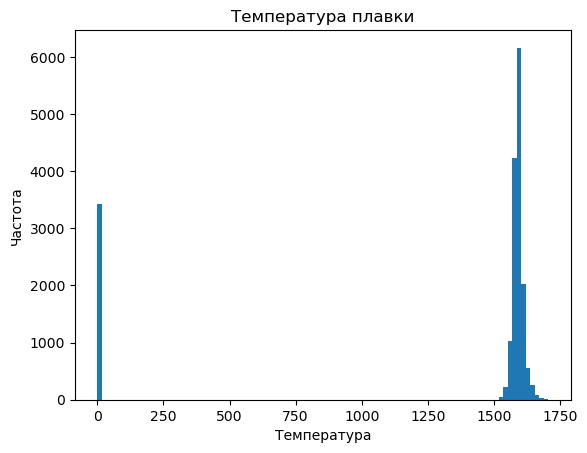

In [86]:
plt.title('Температура плавки')
plt.hist(temp_new.temperature, bins= 100);
plt.xlabel("Температура")  
plt.ylabel("Частота")
plt.show()

In [87]:
temp_new.temperature.describe()

count    18092.000000
mean      1289.406865
std        623.600333
min          0.000000
25%       1567.000000
50%       1586.000000
75%       1597.000000
max       1705.000000
Name: temperature, dtype: float64

In [88]:
temp_new.sample(5)

,key,measurment_time,temperature
43,9,2019-05-03 15:42:17,1589.0
6412,1145,2019-06-16 04:22:41,1588.0
15523,2774,2019-08-20 22:01:21,0.0
4383,784,2019-06-03 01:16:39,1593.0
11702,2087,2019-07-26 11:32:02,1585.0


По условию задачи температура ниже 1500 град.С считется нарушением технологического процесса

In [90]:
key_to_delete = temp_new[temp_new.temperature < 1500].key.values

In [91]:
temp_new = temp_new[~temp_new.key.isin(key_to_delete)]

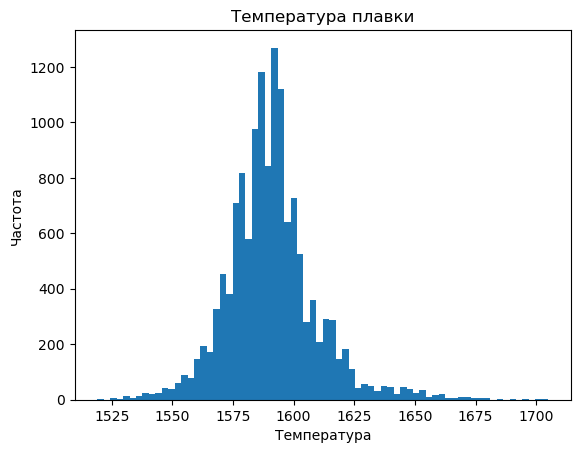

In [92]:
plt.title('Температура плавки')
plt.hist(temp_new.temperature, bins= 70);
plt.xlabel("Температура")  
plt.ylabel("Частота")
plt.show()

In [93]:
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              13905 non-null  int64  
 1   measurment_time  13905 non-null  object 
 2   temperature      13905 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


До 17 итераций на каждую партию

Для подготовки признаков требуется выделить начальную темпертуру и температуру после последней итерации

In [94]:
sup = temp_new[temp_new.key == 2447] 
sup[sup.measurment_time == sup.measurment_time.min()].temperature.values[0]

1640.0

In [95]:
sup[sup.measurment_time == sup.measurment_time.max()].temperature.values[0]

1594.0

In [96]:
def first_last_temperature(df: pd.DataFrame) -> pd.DataFrame:

    to_join = pd.DataFrame(columns = ['first_temperature', 'last_temperature', 'iter_count'], index = df.key.unique())
    for key in df.key.unique():
        sup = temp_new[temp_new.key == key]
        to_join.loc[key, 'first_temperature'] = float(sup[sup.measurment_time == sup.measurment_time.min()].temperature.values[0])
        to_join.loc[key , 'last_temperature'] = float(sup[sup.measurment_time == sup.measurment_time.max()].temperature.values[0])
        to_join.loc[key , 'iter_count'] = float(sup.key.count())
    return to_join

In [98]:
temp_to_join = pd.DataFrame()

In [99]:
temp_to_join['first_temperature'] = temp_new.groupby('key').agg({'temperature':['first']})
temp_to_join['last_temperature'] = temp_new.groupby('key').agg({'temperature':['last']})
temp_to_join['iter_count'] = temp_new.groupby('key').key.count()

In [101]:
temp_to_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2473 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temperature  2473 non-null   float64
 1   last_temperature   2473 non-null   float64
 2   iter_count         2473 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


In [102]:
temp_to_join['key'] = temp_to_join.index

In [103]:
temp_to_join = temp_to_join.reset_index(drop = True)

In [104]:
temp_to_join.sample(5)

,first_temperature,last_temperature,iter_count,key
1936,1632.0,1594.0,5,1954
115,1652.0,1600.0,7,118
877,1571.0,1598.0,7,890
932,1592.0,1584.0,6,945
177,1578.0,1609.0,9,180


In [105]:
temp_to_join.isna().sum()

first_temperature    0
last_temperature     0
iter_count           0
key                  0
dtype: int64

Вывод: 

- Храктер распредения - нормальный
- Температура плавки в среднем изменяется в пределах +- 10 град.С (от 1580 до 1599 град.С)
- В среднем температура плавки 1590 град.С

**bulk_new**

In [106]:
columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

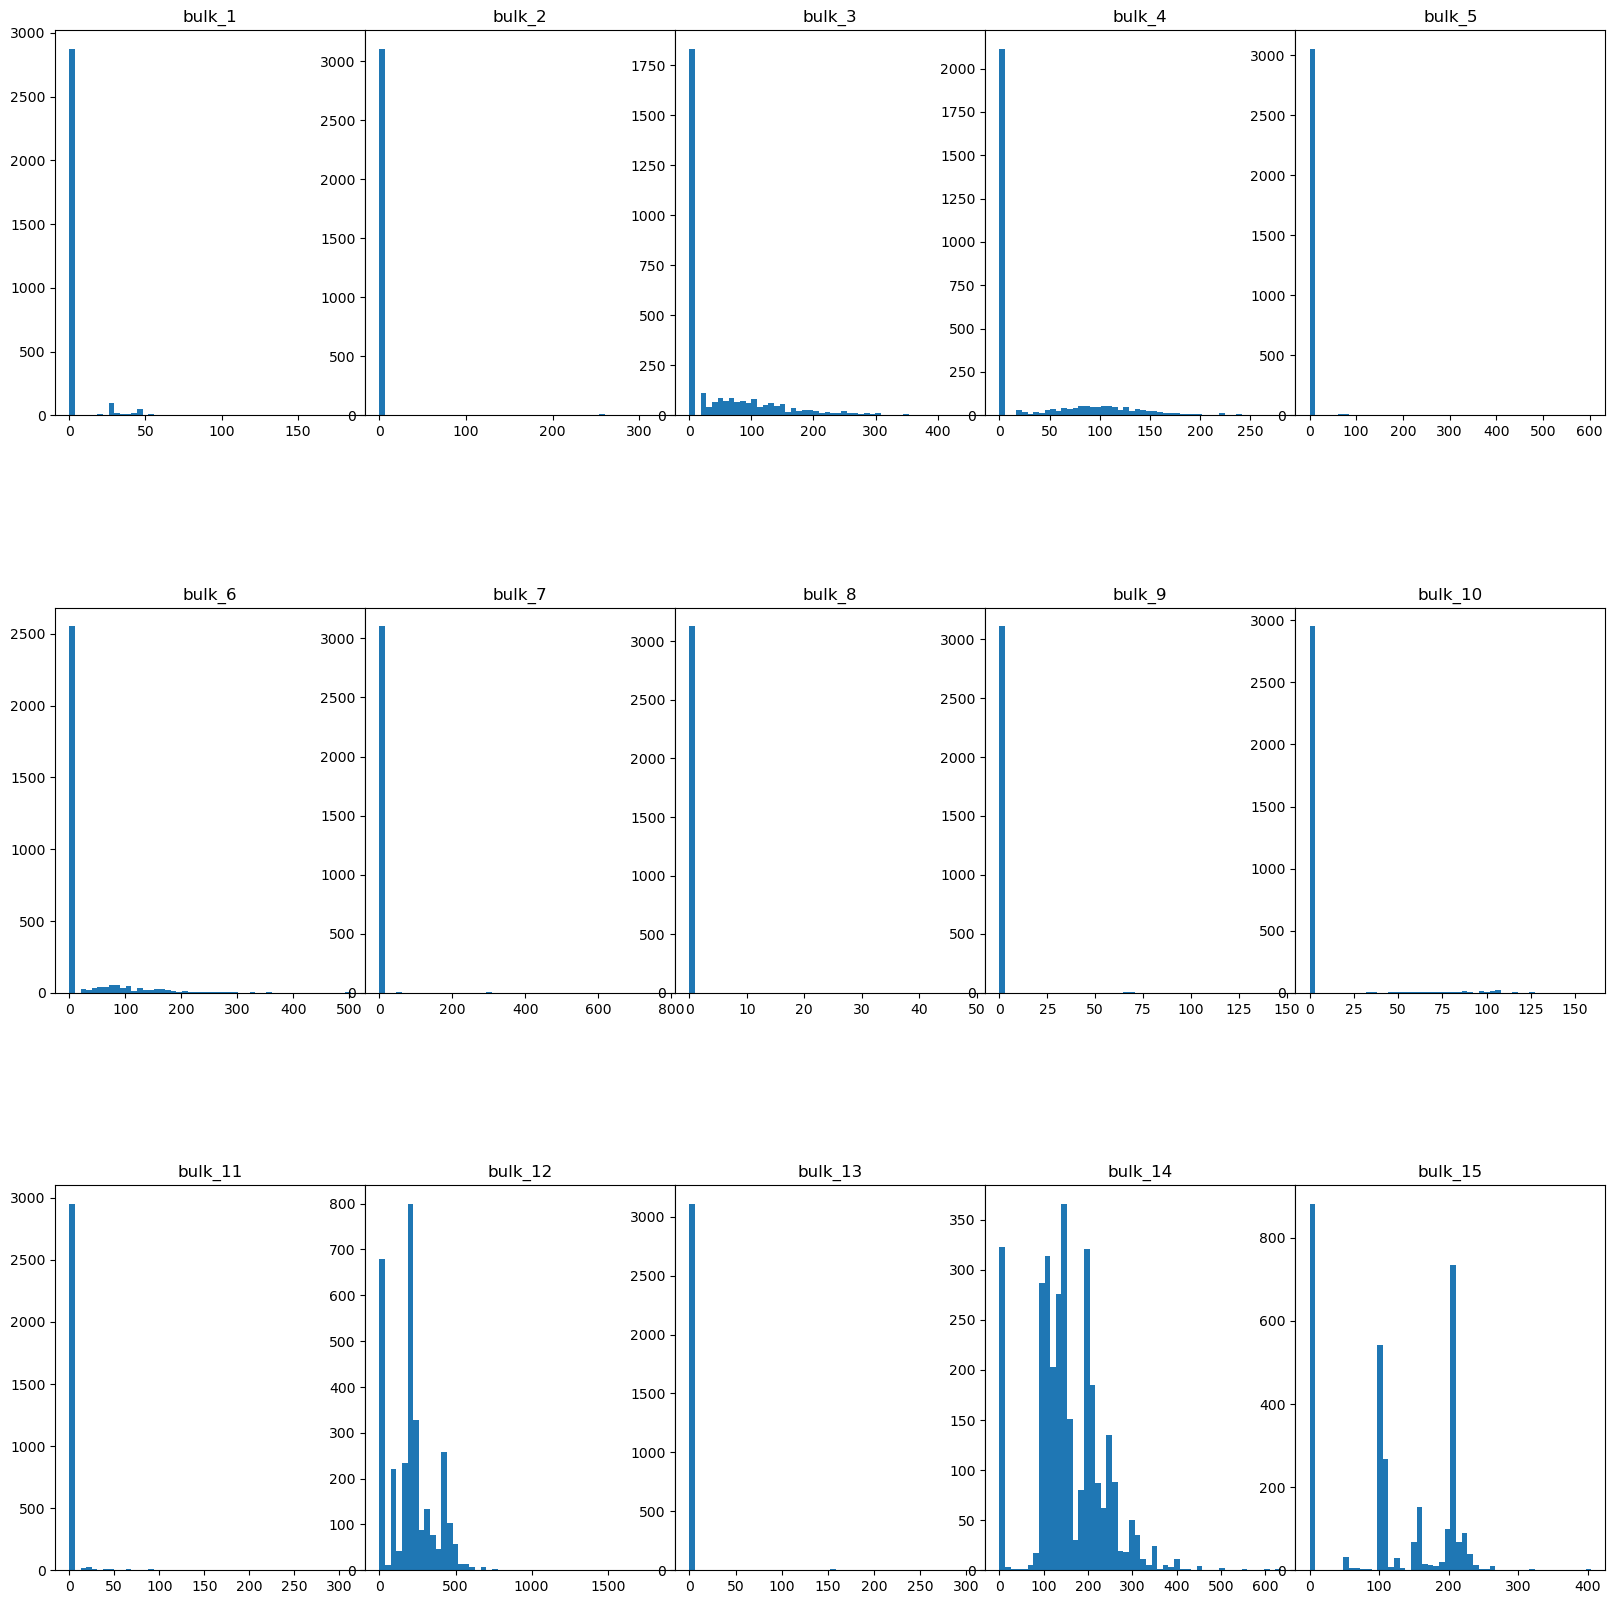

In [107]:
plot_cycle(bulk_new, columns, 3, 5, 50)

In [108]:
bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Вывод: 

- Материалы 1..11, 13 практически всегда подются в одинаковых количествах
- Материалы 12, 14, 15 могут подаваться в разных количествах в зависимости от режима технологического процесса

In [109]:
def box_cycle(df:pd.DataFrame, columns:list, string:int, col:int):
    fig, axs = plt.subplots(string,col, figsize= (20,20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i in range(len(columns)):

        axs[i].boxplot(df[columns[i]])
        axs[i].set_title(columns[i])
    return 

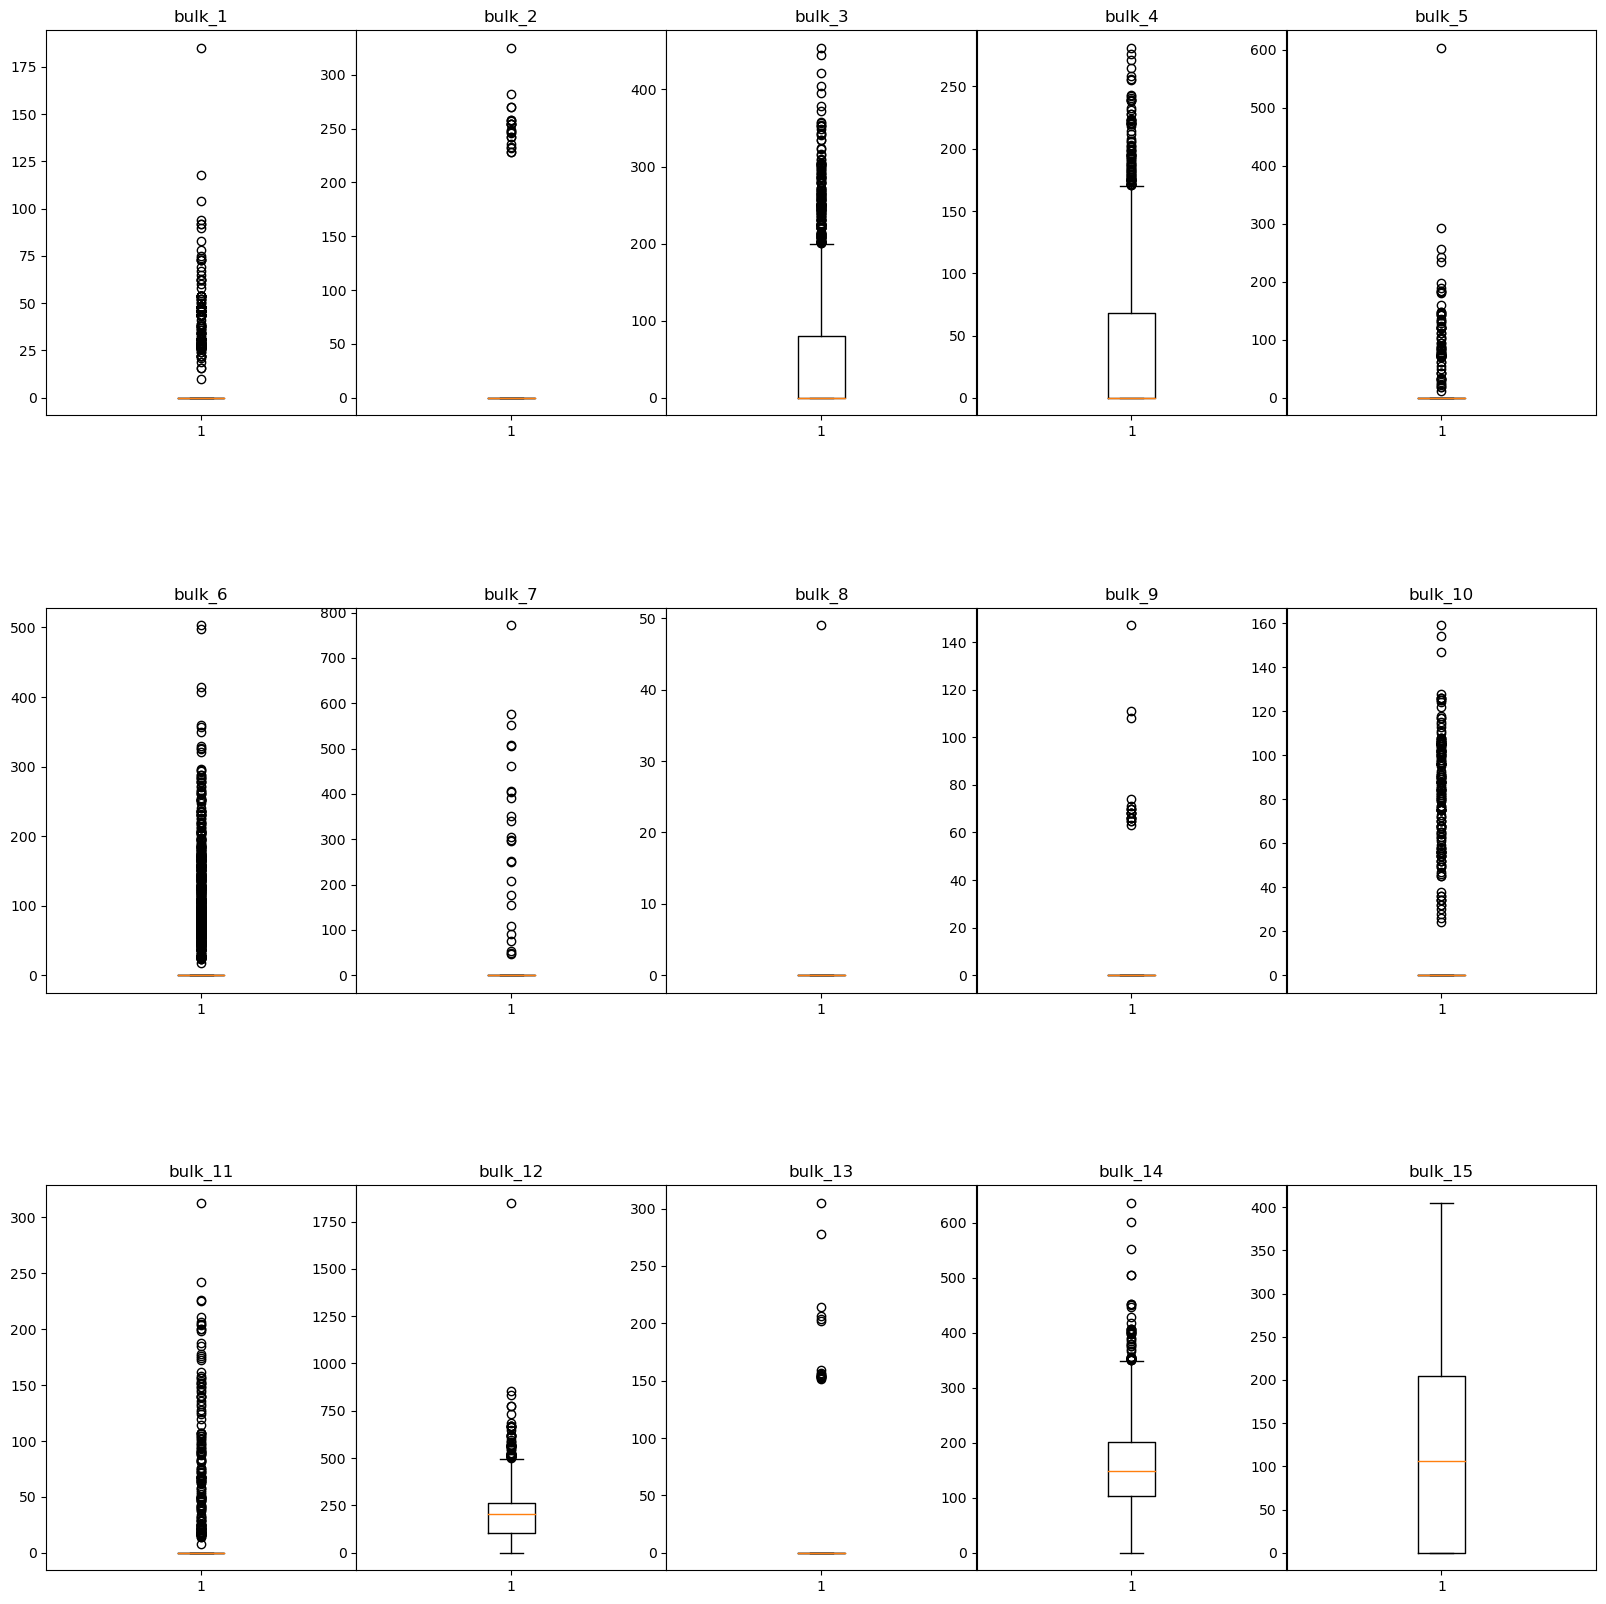

In [110]:
box_cycle(bulk_new, columns, 3, 5)

**wire_new**

In [111]:
columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

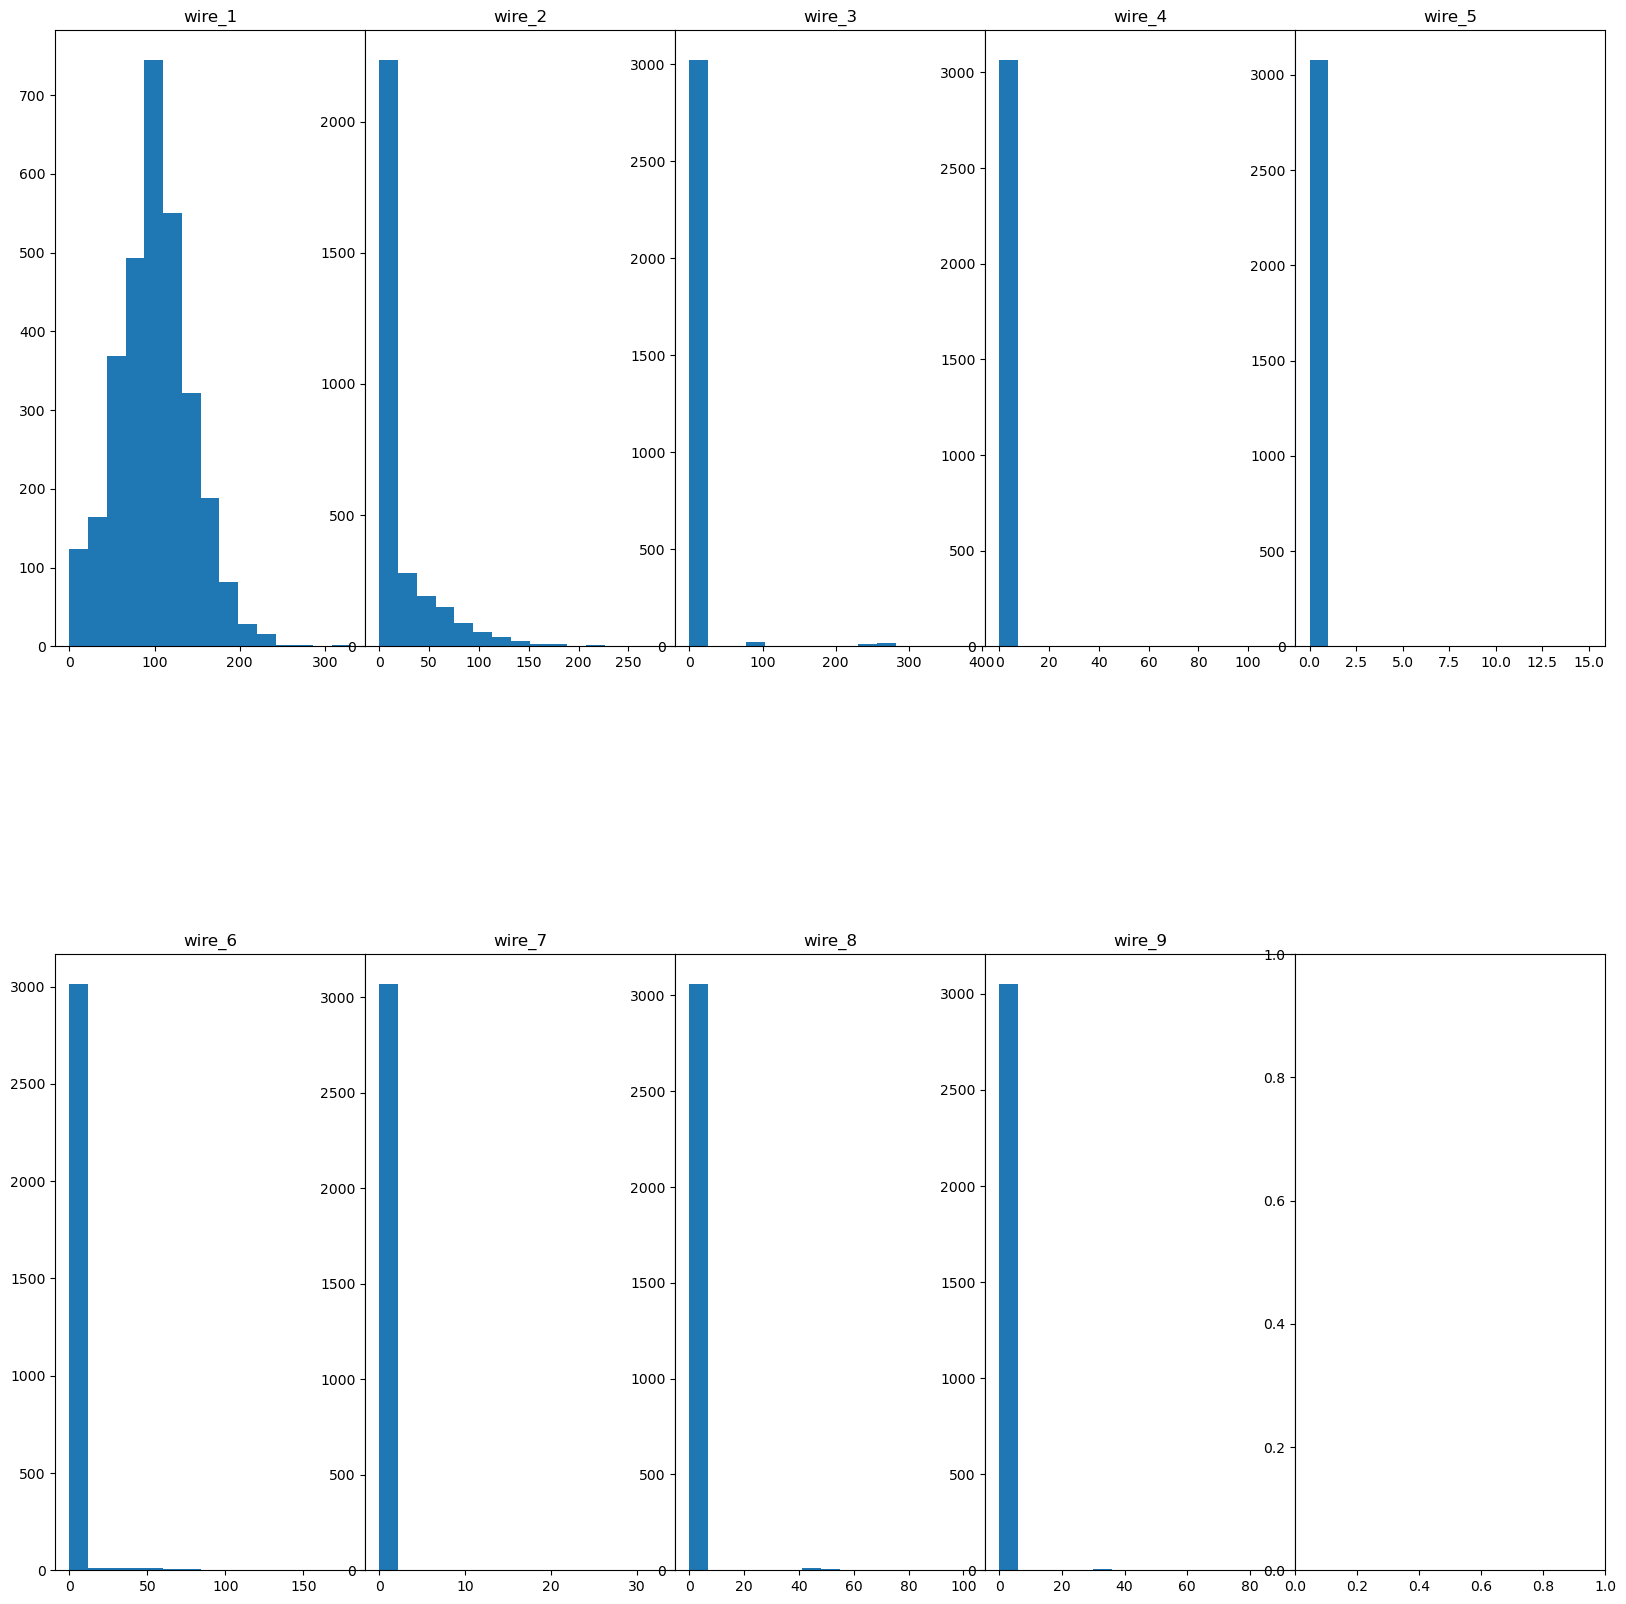

In [112]:
plot_cycle(wire_new, columns, 2,5,15)

In [113]:
wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Вывод: 

- Проволка 2...9 практически всегда подются в одинаковых количествах
- Проволка 1 может подаваться в разных количествах в зависимости от режима технологического процесса

**Общий вывод по этапу:** 

Очевидно что время подачи материала и проволки, время замеров и другие "времена" не требуются для обучения модели так как с темпертурой плавки никак не коррелируют. Их в итоговый датафрейм объединять не будем

# 4 Объединение данных

In [114]:
temp_to_join.index = temp_to_join.key
bulk_new.index = bulk_new.key
gas_new.index = gas_new.key
wire_new.index = wire_new.key

In [115]:
temp_to_join = temp_to_join.drop(columns= ['key'])
bulk_to_join = bulk_new.drop(columns= ['key'])
gas_to_join = gas_new.drop(columns= ['key'])
wire_to_join = wire_new.drop(columns= ['key'])

In [116]:
united_new = (arc_preprocessed
              .join(temp_to_join, how='inner')
              .join(bulk_to_join, how='inner')
              .join(gas_to_join, how='inner')
              .join(wire_to_join, how='inner'))

In [117]:
united_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2324 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_power         2324 non-null   float64
 1   time_of_heating    2324 non-null   float64
 2   first_temperature  2324 non-null   float64
 3   last_temperature   2324 non-null   float64
 4   iter_count         2324 non-null   int64  
 5   bulk_1             2324 non-null   float64
 6   bulk_2             2324 non-null   float64
 7   bulk_3             2324 non-null   float64
 8   bulk_4             2324 non-null   float64
 9   bulk_5             2324 non-null   float64
 10  bulk_6             2324 non-null   float64
 11  bulk_7             2324 non-null   float64
 12  bulk_8             2324 non-null   float64
 13  bulk_9             2324 non-null   float64
 14  bulk_10            2324 non-null   float64
 15  bulk_11            2324 non-null   float64
 16  bulk_12            2324 non-n

In [118]:
united_new.sample(5)

,full_power,time_of_heating,first_temperature,last_temperature,iter_count,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
812,0.625838,345.0,1573.0,1587.0,4,0.0,0.0,0.0,0.0,0.0,...,5.168057,19.047600,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
283,0.984274,109.0,1587.0,1594.0,7,0.0,0.0,80.0,0.0,0.0,...,18.167295,125.143204,35.147839,0.0,0.0,0.0,0.0,0.0,46.094879,0.0
215,0.712282,166.0,1594.0,1624.0,6,0.0,0.0,0.0,123.0,0.0,...,7.385211,126.322556,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1264,0.782379,206.0,1570.0,1606.0,5,0.0,0.0,0.0,123.0,0.0,...,6.392302,134.128800,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2159,0.491696,127.0,1628.0,1593.0,4,0.0,0.0,99.0,0.0,0.0,...,6.553961,112.257604,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [119]:
len(united_new.columns)

30

In [120]:
united_new.isna().sum()

full_power           0
time_of_heating      0
first_temperature    0
last_temperature     0
iter_count           0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
gas                  0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
dtype: int64

# 5 Исследовательский анализ объединенного датафрейма

## 5.1 Построение матрицы корреляций

Скорее всего все имеющиеся признаки были уже добавлены. Построим распределения выбранных признаков

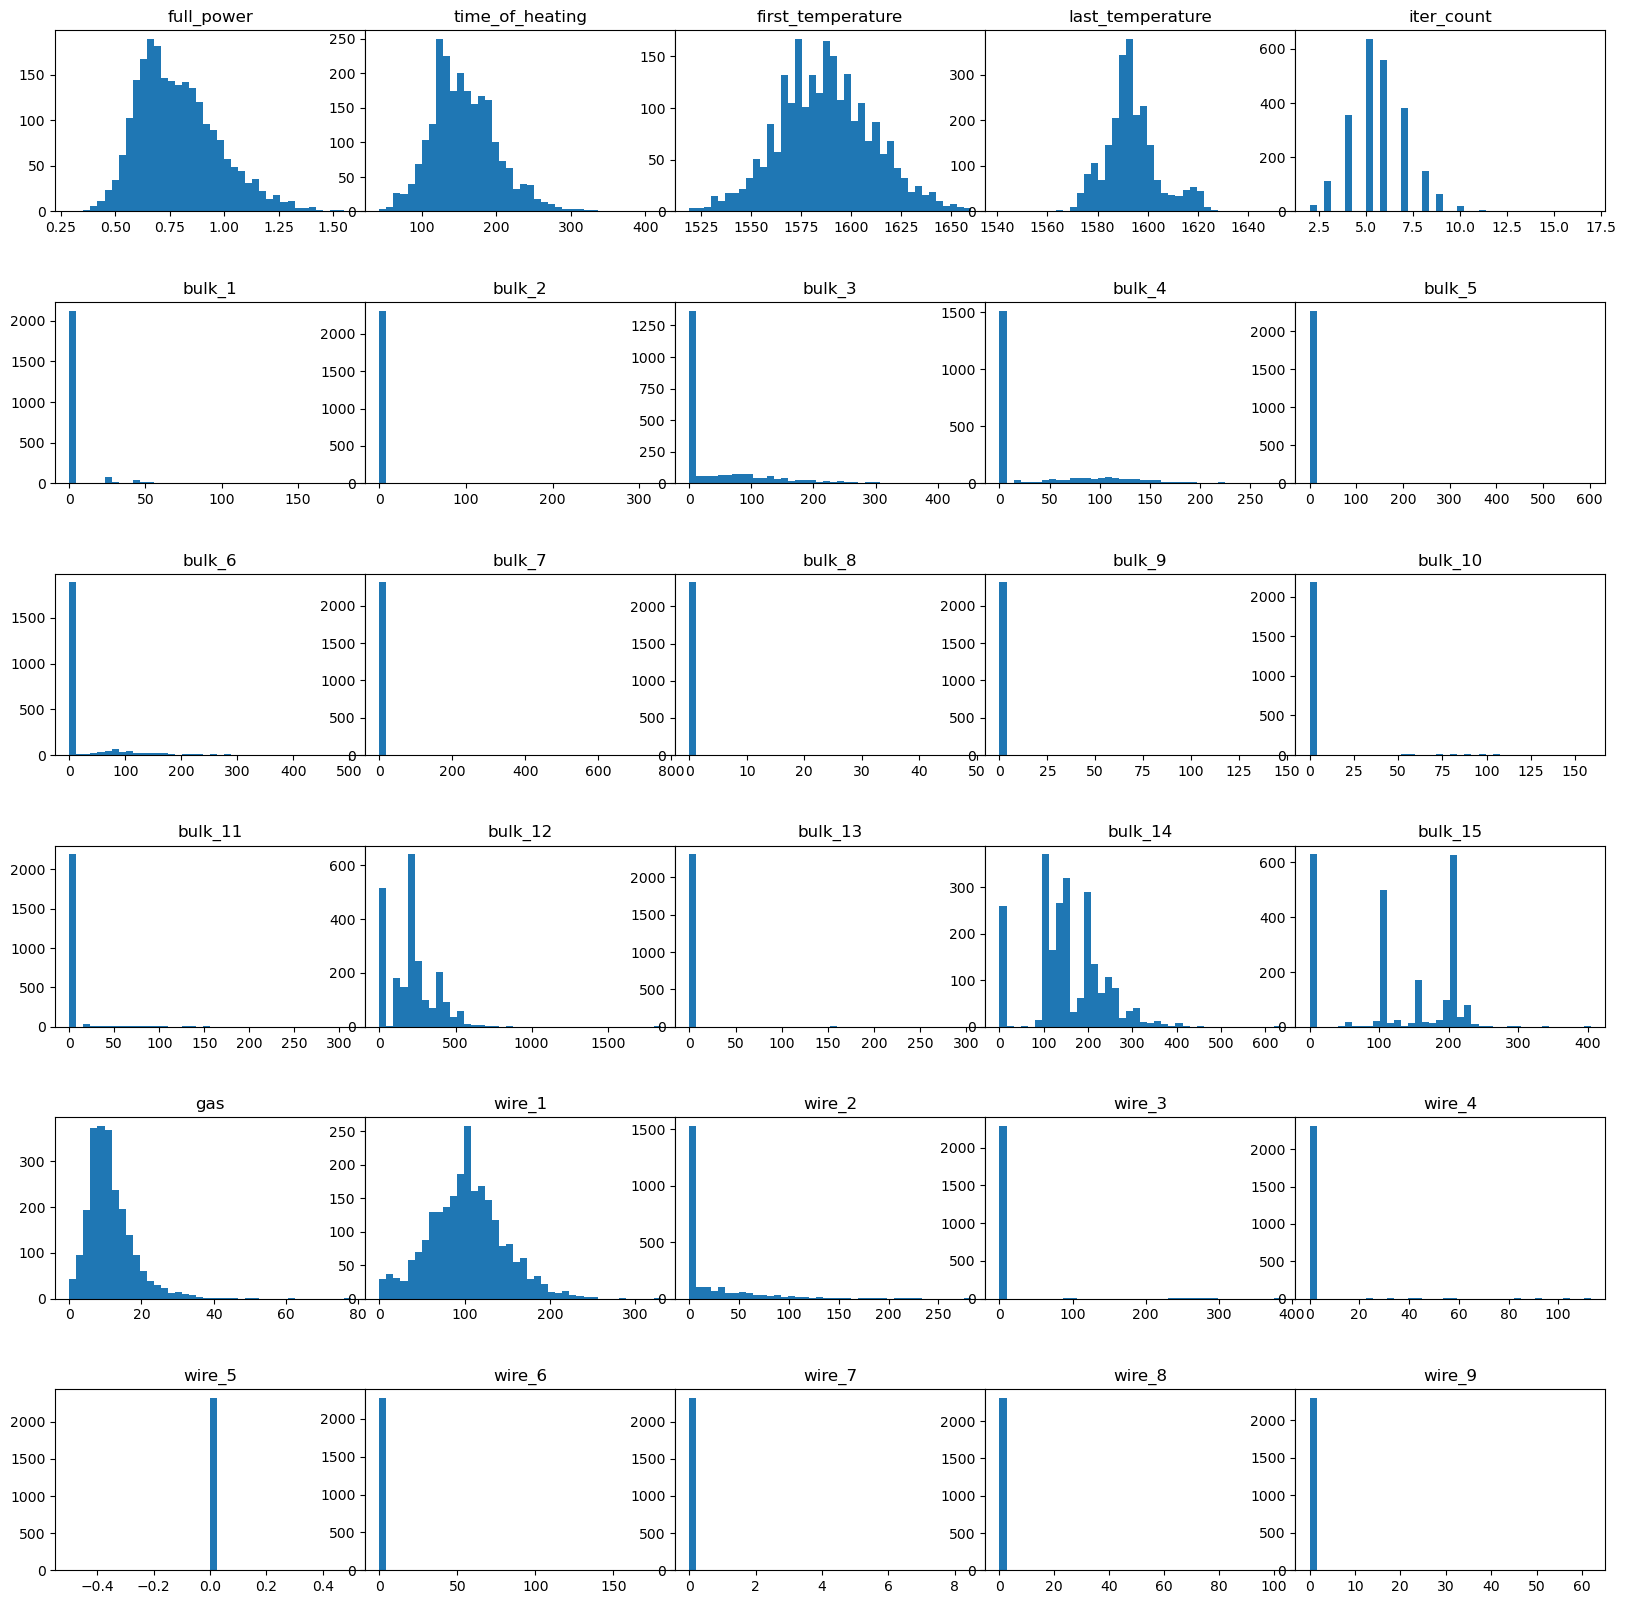

In [121]:
plot_cycle(united_new, united_new.columns, 6, 5, 40)

Посчитаем корреляции и построим матрицу корреляций

In [122]:
corr = united_new.corr()
corr.style.background_gradient(cmap='coolwarm')

,full_power,time_of_heating,first_temperature,last_temperature,iter_count,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
full_power,1.000000,0.030910,0.002587,0.026218,-0.014729,0.025462,-0.012651,0.011009,0.029104,-0.012964,-0.014735,-0.007710,-0.036683,-0.016356,-0.008285,0.005446,0.026752,-0.011893,0.011330,0.020142,0.026267,0.032326,-0.026250,0.020807,-0.013411,nan,-0.013273,-0.006827,-0.012488,0.005501
time_of_heating,0.030910,1.000000,-0.341211,0.122957,-0.109416,0.050708,-0.031134,0.016539,-0.009303,-0.017145,0.019975,-0.030094,-0.017857,-0.041009,-0.021148,0.025877,0.209636,-0.010486,0.180763,0.192320,0.031133,-0.097203,-0.000315,0.016652,-0.038162,nan,0.019771,-0.026346,-0.038297,0.011769
first_temperature,0.002587,-0.341211,1.000000,0.301882,-0.176861,0.079098,0.141547,-0.113380,0.165484,0.078729,-0.127046,0.087774,-0.011742,-0.033394,0.035789,-0.110430,-0.079574,0.020237,-0.179991,-0.062382,0.036736,0.262880,-0.101101,-0.003403,0.076126,nan,0.020733,0.052812,-0.029831,0.002639
last_temperature,0.026218,0.122957,0.301882,1.000000,0.180276,-0.075428,-0.082543,-0.037156,0.187817,-0.028446,-0.180906,-0.107371,-0.026613,-0.016130,0.061227,-0.114936,0.266805,-0.010974,0.114893,0.265772,0.059079,0.317488,-0.207242,-0.047636,-0.159839,nan,-0.084149,-0.137349,-0.010818,-0.027561
iter_count,-0.014729,-0.109416,-0.176861,0.180276,1.000000,0.097689,0.093145,0.107308,-0.004955,0.075031,0.153168,0.152653,-0.009001,0.038229,0.012517,0.062526,0.306377,0.117830,0.333801,0.173835,0.404053,0.137893,0.078226,0.055255,0.113763,nan,0.053380,0.073747,0.043910,-0.024671
bulk_1,0.025462,0.050708,0.079098,-0.075428,0.097689,1.000000,0.224677,-0.011538,0.041662,0.060365,-0.003581,0.237195,-0.005737,-0.019800,-0.023333,-0.038008,0.325724,-0.010325,0.207606,-0.001211,0.234089,0.013823,-0.009261,0.020204,0.146276,nan,0.148509,0.083432,-0.019579,0.011013
bulk_2,-0.012651,-0.031134,0.141547,-0.082543,0.093145,0.224677,1.000000,-0.046953,0.040756,0.360291,-0.030001,0.679352,-0.001549,-0.005344,-0.018055,0.001449,-0.099125,-0.005604,-0.141185,-0.105898,0.217443,-0.169623,-0.039080,0.223188,0.699339,nan,0.558882,0.431735,-0.005285,-0.006857
bulk_3,0.011009,0.016539,-0.113380,-0.037156,0.107308,-0.011538,-0.046953,1.000000,-0.295526,-0.006766,0.066316,-0.033521,0.020875,0.011390,-0.085266,-0.007383,0.018059,-0.013385,0.011209,-0.013181,0.059665,0.037788,0.094897,0.005840,-0.040582,nan,0.007174,-0.019475,0.004885,0.004668
bulk_4,0.029104,-0.009303,0.165484,0.187817,-0.004955,0.041662,0.040756,-0.295526,1.000000,0.028273,-0.251577,0.045866,-0.013209,-0.002995,-0.084975,-0.119733,0.105190,0.003154,-0.091103,0.100833,0.017532,0.298145,-0.268115,-0.039326,0.034390,nan,-0.011507,0.033822,0.007781,-0.058236
bulk_5,-0.012964,-0.017145,0.078729,-0.028446,0.075031,0.060365,0.360291,-0.006766,0.028273,1.000000,-0.021853,0.288327,-0.002448,-0.008449,-0.028544,-0.015888,-0.072951,-0.008860,-0.066101,-0.067426,0.086869,-0.013454,-0.013811,0.070889,0.262752,nan,0.204796,0.172136,-0.008355,-0.010840


Посмотрим на корреляции к финальной температуре

In [123]:
corr_last_temp = corr.loc[:,'last_temperature'].drop('last_temperature')

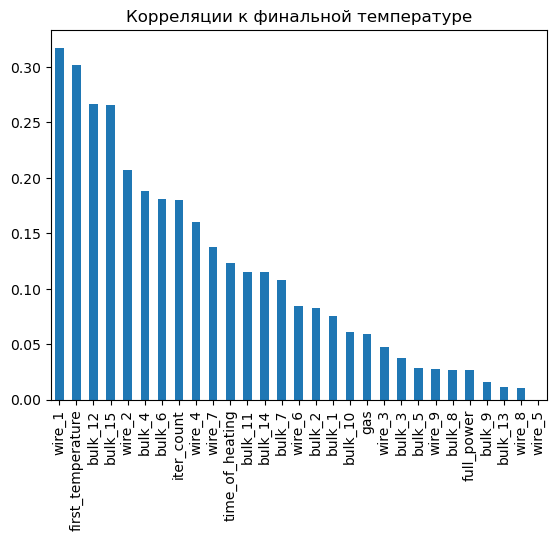

In [124]:
plt.title('Корреляции к финальной температуре')
abs(corr_last_temp).sort_values(ascending= False).plot(kind = 'bar');

Ниже построил хитмэп

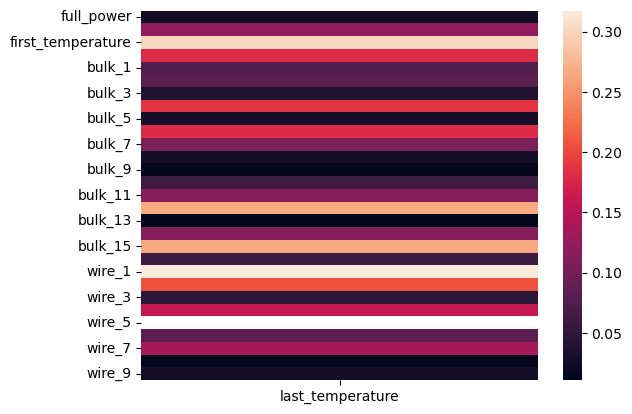

In [125]:
sns.heatmap(pd.DataFrame(corr_last_temp.map(lambda x: abs(x))));

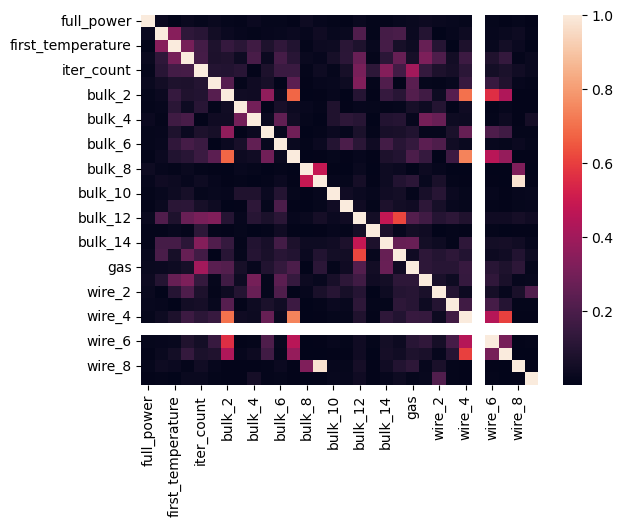

In [126]:
sns.heatmap(pd.DataFrame(corr.apply(lambda x: abs(x))));

Wire 5 только грузит модель. Удалим его из признков

In [127]:
united_new = united_new.drop(columns = 'wire_5')

## 5.2 Анализ важности признаков

Наиболее влиятельными признаками являются:
            - wire 1(количество поданой проволки 1) ~ 0.3
            - first_temperature (температура подаваемого материала)  ~ 0.3
            - bulk 12 (количество поданого сыпучего материала 12)  ~ 0.27
            - bulk 15 (количество поданого сыпучего материала 15)  ~ 0.27
            - wire 2 (количество поданой проволки 2)  ~ 0.2
            - bulk 4 (количество поданого сыпучего материала 4)~ 0.19
            - bulk 6 (количество поданого сыпучего материала 6)~ 0.19
            - wire 4 (количество поданой проволки 4)~ 0.19
            - bulk 7 (количество поданого сыпучего материала 7)~ 0.11
            - time_of_heating (время нагрева)~ 0.11
            - bulk 11(количество поданого сыпучего материала 11) ~ 0.11
            - bulk 14 количество поданого сыпучего материала 14) ~ 0.11

Вывод: самое большое влияние оказывают температура с которой чугун был подан на плавку и некоторые примеси. 

# 6 Построение модели

## 6.1. Подготовка выборок

Согласно условиям задачи

In [128]:
random_state = 310124
test_size = 0.25

Подготовим выборки

In [129]:
features = united_new.drop(columns=['last_temperature'])
target = united_new['last_temperature']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= test_size, random_state= random_state)

Проверим рамеры выборок

In [131]:
X_train.shape

(1743, 28)

In [132]:
X_test.shape

(581, 28)

In [133]:
y_train.shape

(1743,)

In [134]:
y_test.shape

(581,)

Можно переходить к построению модели

## 6.2. Построение и выбор модели

Категориальных признаков нет

In [135]:
numeric_features = X_train.columns

params = {}
model = LinearRegression()
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

In [136]:
pipeline = make_pipeline(preprocessor,model)

In [137]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['full_power', 'time_of_heating', 'first_temperature', 'iter_count',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'gas', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_6', 'wire_7', 'wire_8', 'wire_9'],
      dtype='object'))])),
                ('linearregression', LinearRegression())])

In [138]:
gs = GridSearchCV(pipeline, params, cv=5, return_train_score=True, scoring='neg_mean_absolute_error')

In [139]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['full_power', 'time_of_heating', 'first_temperature', 'iter_count',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'gas', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_6', 'wire_7', 'wire_8', 'wire_9'],
      dtype='object'))])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, return_train_score=True,
             scoring='neg_mean_absolute_error')

Оценка кросс валидацией

In [140]:
abs(gs.best_score_)

8.037459725864462

MAE > 6.8. Перейдем к бустингу

In [141]:
model = LGBMRegressor(random_state= random_state)

In [142]:
params = {'n_estimators': [15, 20, 30, 55], 'num_leaves': [30, 40, 50, 60], 'max_depth': [15,25,30, 40]}
gs = GridSearchCV(model, params, cv=5, return_train_score=True, scoring='neg_mean_absolute_error')

In [143]:
gs.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 19
[LightGBM] [Info] Start training from score 1593.096126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 19
[LightGBM] [Info] Start training from score 1593.432568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=310124),
             param_grid={'max_depth': [15, 25, 30, 40],
                         'n_estimators': [15, 20, 30, 55],
                         'num_leaves': [30, 40, 50, 60]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [144]:
abs(gs.best_score_)

6.777038815198661

In [145]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 30, 'num_leaves': 50}

Выберем бустинг в качестве модели

In [146]:
model = LGBMRegressor(random_state= random_state, max_depth = 15, n_estimators = 55, num_leaves= 30)

In [147]:
model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 19
[LightGBM] [Info] Start training from score 1593.277682


LGBMRegressor(max_depth=15, n_estimators=55, num_leaves=30, random_state=310124)

## 6.3. Тест модели

На тестовой выборке

In [148]:
mean_absolute_error(model.predict(X_test), y_test)

6.333713582515591

MAE < 6.8. Задача выполнена

Сравним с DummyRegressor

In [149]:
model = DummyRegressor(strategy= 'median')
model.fit(X_train,y_train)
mean_absolute_error(model.predict(X_test), y_test)

7.771084337349397

# 7 Общий вывод

## 7.1. Постановка задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса

**Цель работы:**

    Построить модель c MAE < 6.8

Задача была разбита не несколько этапов:

1. Описание проекта
2. Импорт библиотек и датасета
3. Исследовательский анализ данных
4. Подготовка объединенного датафрейма
5. Исследовательский нализ объединенного датафрейма
6. Построение модели
7. Общий вывод

В ходе первого этапа (Описание проекта) была сформулированна задача

В ходе первого этапа (импорт библиотек и згрузка датафреймов) были загружены необходимые библиотеки и данные

В ходе третьего этапа (Исследовательский анализ данных) была произведены предобработка данных и исследовательский анализ данных

В ходе предобработки данных выявлено следующее:

1. Признаках реактивной мощности и температуры присутствуют аномальные значения (отрицательное и <1500 град.С)
2. В датасетах bulk, bulk_time, wire, wire_time, temp присутствуют пропуски
3. Даты подгруженны не корректно
4. Наименования признаков отличаются от snake_case

В ходе предобработки данных было выполнено:

1. В признаках bulk и wire пропуски были заполнены нулями, так как скорее всего NaN означает, что мтериал не подавался
2. Для дальнейшей работы пропуски в признаке temp были заполнены заглушкой
3. Наименования признков были приведены к snake_case
4. Даты приведены к date_time

В ходе исследовательского анализа данных были построены диаграммы размаха (ящики с усами) и гистограмм для признаков.

В ходе исследовательского анлиза данных выяснили: 

1. Очевидно что время подачи материала и проволки, время замеров и другие "времена" не требуются для обучения модели так как с темпертурой плавки никак не коррелируют. Их не требуется включать в финальный датафрейм
2. Выбросы обсуловлены бОльшим количеством итераций, добавками, увеличением темпертуры


В ходе этапа 4 (Объединение датафремов) был подготовлен объединенный по общему ключу датафрейм. В итоговый датафрейм вошли только те ключи, которые встречаются во всех датасетах

В ходе 5-ого этапа (Исследовательский нализ объединенного датафрейма) был проведен корреляционный анализ данных. Построены матрицы кореляции

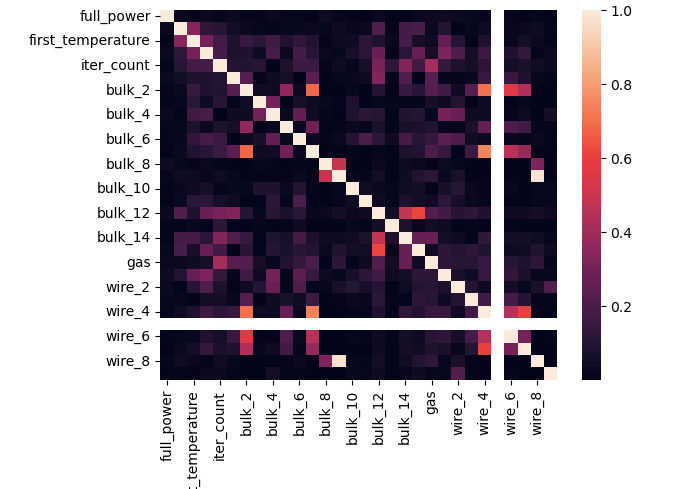

Наиболее влиятельными признаками являются: 
   - wire 1(количество поданой проволки 1) с корреляцией ~ 0.3
   - first_temperature (температура подаваемого материала) с корреляцией ~ 0.3
   - bulk 12 (количество поданого сыпучего материала 12) с корреляцией ~ 0.27
   - bulk 15 (количество поданого сыпучего материала 15) с корреляцией ~ 0.27
   - wire 2 (количество поданой проволки 2) с корреляцией ~ 0.2
   - bulk 4 (количество поданого сыпучего материала 4) с корреляцией ~ 0.19
   - bulk 6 (количество поданого сыпучего материала 6) с корреляцией~ 0.19
   - wire 4 (количество поданой проволки 4) с корреляцией~ 0.19
   - bulk 7 (количество поданого сыпучего материала 7) с корреляцией~ 0.11
   - time_of_heating (время нагрева) с корреляцией ~ 0.11
   - bulk 11(количество поданого сыпучего материала 11) с корреляцией ~ 0.11
   - bulk 14 количество поданого сыпучего материала 14) с корреляцией ~ 0.11

В ходе этапа 6 (Построение модели) были подготовлены признаки и целевой признак. В качестве целевого признака была принята финальная температура. Были подготовлены выборки. Размер тестовой выборки принят 25%. Были построены и протестированны модели

В качестве модели были приняты Линейная регрессия и градиентный бустинг. Для защиты от переобуения проверка моделей проводилась кросс валидацией на обучающей выборке. Результаты для тестовой выборки даны ниже:

Линейная регрессия MAE = 8.037 > 6.8
Градиентный бустинг MAE = 6.7 < 6.8

Так как бустинг удовлетворяет условию задачи выбрали бустинг

Результаты на тестовой выборке:

MAE 6.3

MAE 6.3 удовлетворяют условию задачи